In [254]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
from IPython.display import Image

pal = sns.color_palette()
plt.style.use('ggplot')
%config InlineBackend.figure_format='retina'
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)


### Business / Policy Question
---

Migration is a high in the political and policy agenda. Can we predict the next migration wave?

### User
---

World Bank and policy makers of both countries of origin and destination

### Objective
---

__
Identify a predictive model migration fluxes, based on existing indicators produced or collected by the World Bank. 
__

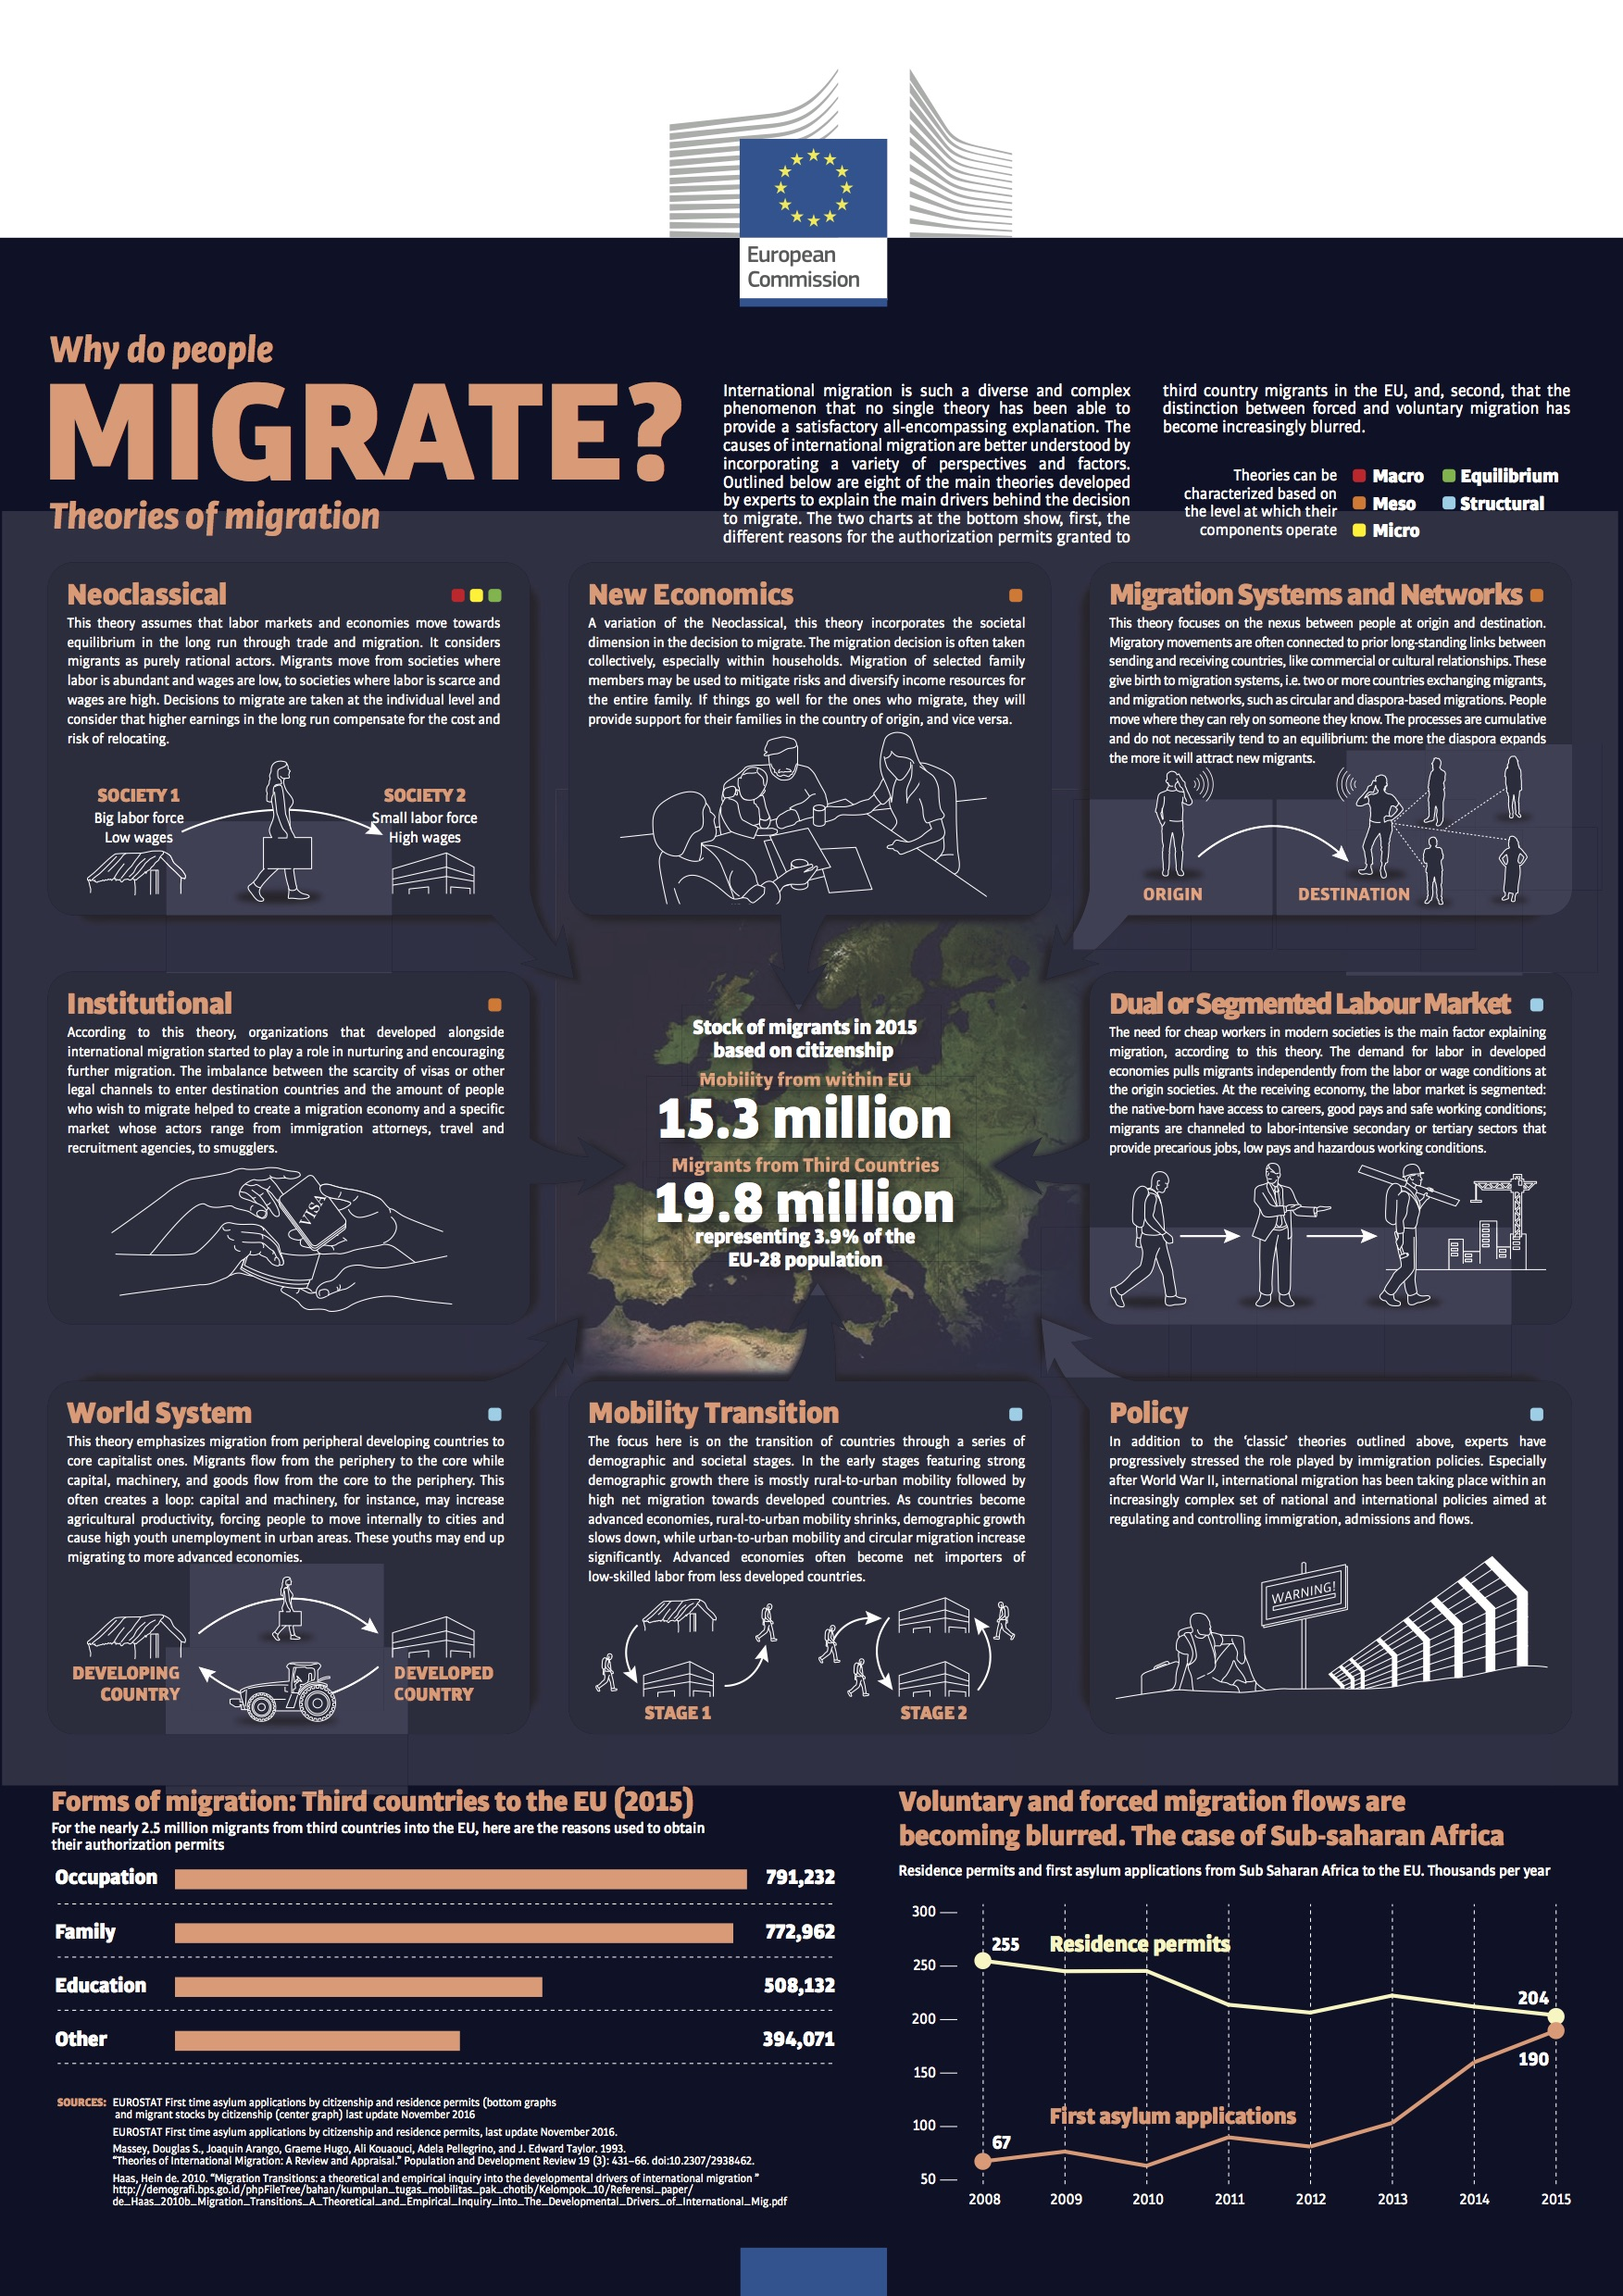

In [259]:
Image("figures/theoriesofmigration.jpg",width=1000)

### Data availability
___

Data are free and available at http://databank.worldbank.org/data/home.aspx

### Load and inspect data

In [3]:
# load migration data
df_migr_raw = pd.read_csv('data/migration_data.csv')

In [4]:
df_migr_raw.head()

Country Origin Name Country Origin Code Migration by Gender Name  \
0         Afghanistan                 AFG                   Female   
1         Afghanistan                 AFG                   Female   
2         Afghanistan                 AFG                   Female   
3         Afghanistan                 AFG                   Female   
4         Afghanistan                 AFG                   Female   

  Migration by Gender Code Country Dest Name Country Dest Code 1960 [1960]  \
0                      FEM       Afghanistan               AFG           0   
1                      FEM           Albania               ALB           0   
2                      FEM           Algeria               DZA          22   
3                      FEM    American Samoa               ASM           0   
4                      FEM           Andorra               AND           0   

  1970 [1970] 1980 [1980] 1990 [1990] 2000 [2000]  
0           0           0           0           0  
1           0           0           0           0  
2           8           6           5           4  
3           0           0           0           0  
4           0           0           2           3

The table presents migration flows in terms of number of people, by 
1. Country of Origin
2. Gender
3. Country of Destination
4. Decade, from 1960 to 2000

We now select the relevant columns, rename them, and rearrange the database. Specifically, we will move the decade columns as entry, suc that each row is representative of a single observation.

In [5]:
df_migr = df_migr_raw[['Country Origin Name', 'Migration by Gender Code', 'Country Dest Name', 
             '1960 [1960]', '1970 [1970]', '1980 [1980]', '1990 [1990]','2000 [2000]']]
df_migr.columns=['Origin','Gender','Destination','1960','1970','1980','1990','2000']

In [6]:
# rearrange data
df_migr_m = df_migr.melt(id_vars=['Origin','Gender','Destination'],var_name='Year')
df_migr_m['Year'] = df_migr_m['Year'].astype('int64')

We focus on the total migration, i.e. at this stage we do not consider the gender issue.

In [260]:
df_migr_tot = df_migr_m[df_migr_m['Gender']=='TOT']
del df_migr_tot['Gender']

### Analysis of emigration
We first analyze the driving forces for emigration, not considering the destination country

In [8]:
df_migr_tot.value = pd.to_numeric(df_migr_tot.value, errors='coerce')
emigration = df_migr_tot.groupby(['Origin','Year']).sum().reset_index()
emigration.columns = ['Country', 'Year', 'Emigration, total']
emigration.head()

/Users/lraso/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Country  Year  Emigration, total
0  Afghanistan  1960            84039.0
1  Afghanistan  1970           131126.0
2  Afghanistan  1980           373995.0
3  Afghanistan  1990          1054244.0
4  Afghanistan  2000          1179710.0

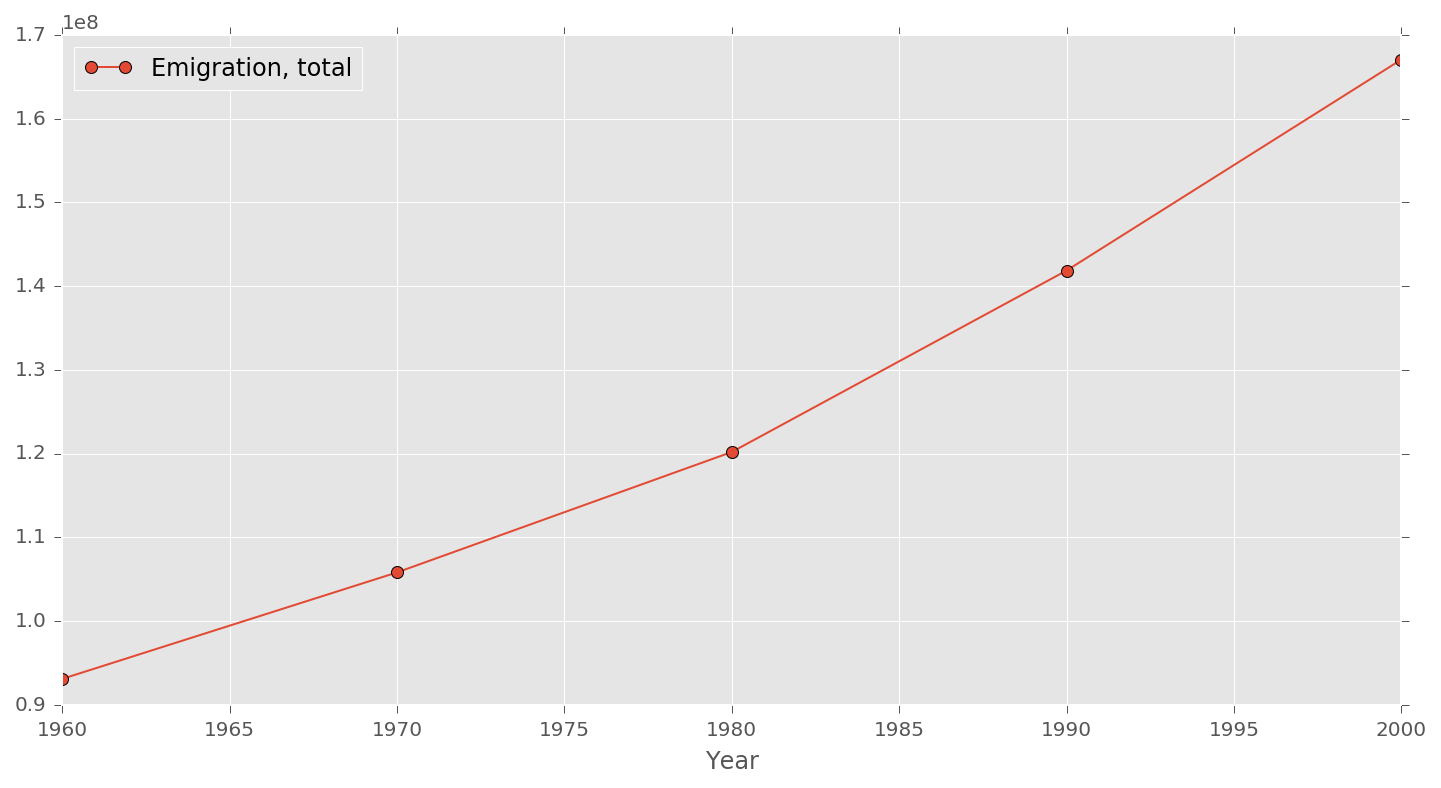

In [257]:
emigration.groupby('Year').sum().plot(marker='o')

The plot above shows how Emigration, in absolute value, has almost doubled in 40 years. This is partially due to the increase in population on the same period. 

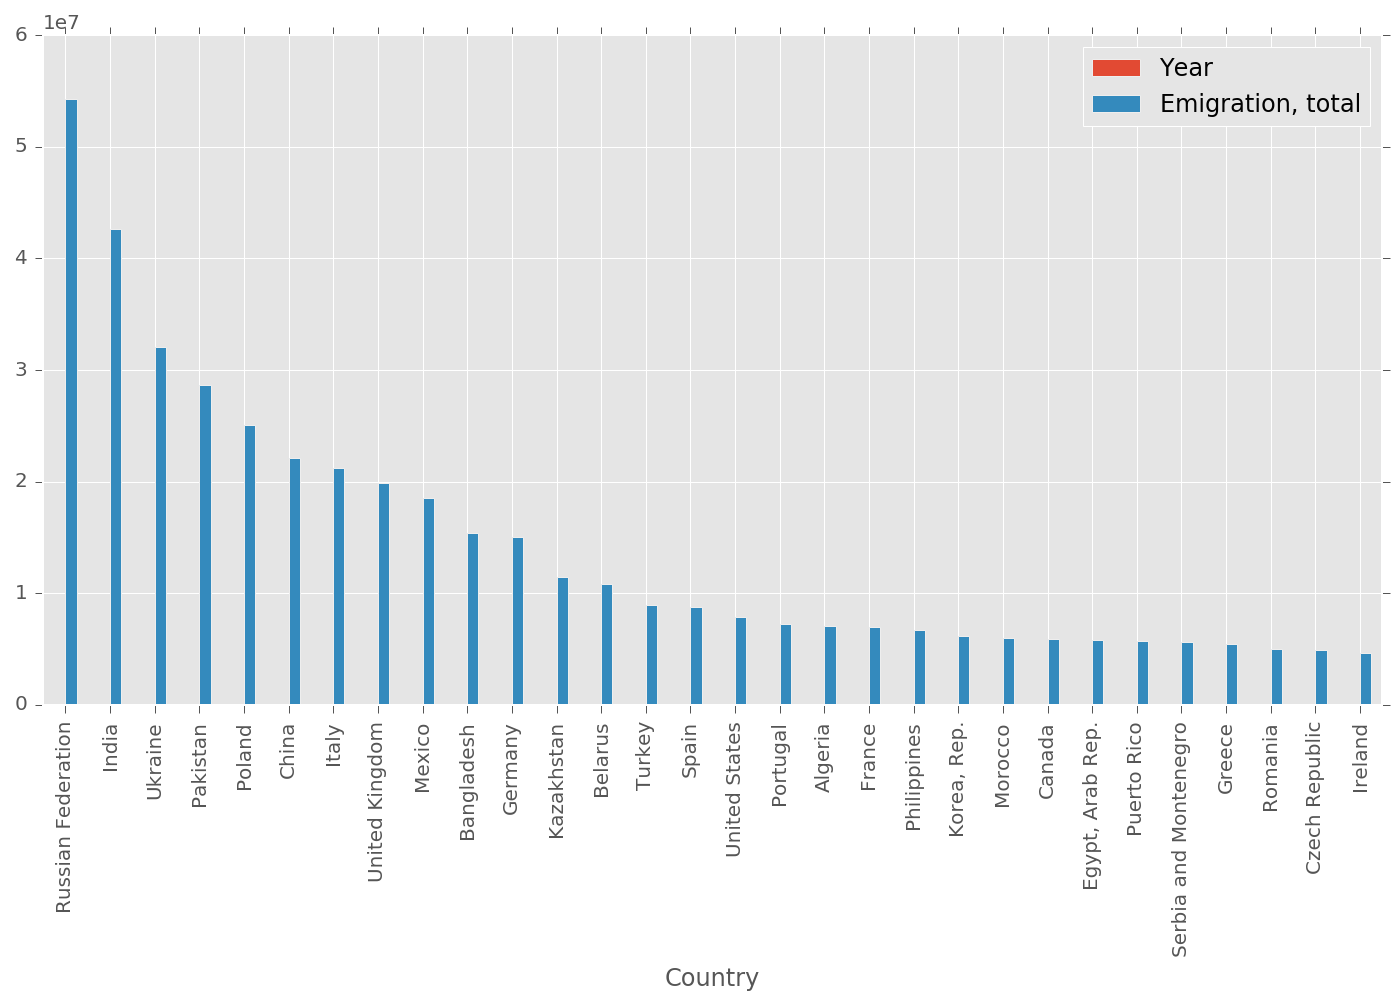

In [258]:
emigration.groupby('Country').sum().sort_values(by='Emigration, total',ascending = False).iloc[0:30].plot(kind='bar')

The plot above shows the countries with the largest absolute emigration flow

This data are not particularly informative, because data-points with large values (big migration flows), dominates their interpretation. A more indicative analysis would require to standardize the data of migration with respect to the country's population. For this reason we use the other World Bank indicators. For this purpose we will use the wbdata module, available at https://github.com/OliverSherouse/wbdata.  

In [11]:
import wbdata

In [285]:
wb_ind_pop = wbdata.search_indicators('Population, Total',source = 2, display=False)
wb_ind_ec = wbdata.search_indicators('GDP per capita',source = 2, display=False)
print(wb_ind_ec[0])

{'id': 'NY.GDP.PCAP.PP.KD', 'sourceOrganization': 'World Bank, International Comparison Program database.', 'topics': [{'id': '3', 'value': 'Economy & Growth'}], 'source': {'id': '2', 'value': 'World Development Indicators'}, 'name': 'GDP per capita, PPP (constant 2011 international $)', 'sourceNote': "GDP per capita based on purchasing power parity (PPP). PPP GDP is gross domestic product converted to international dollars using purchasing power parity rates. An international dollar has the same purchasing power over GDP as the U.S. dollar has in the United States. GDP at purchaser's prices is the sum of gross value added by all resident producers in the economy plus any product taxes and minus any subsidies not included in the value of the products. It is calculated without making deductions for depreciation of fabricated assets or for depletion and degradation of natural resources. Data are in constant 2011 international dollars."}


In [286]:
indicators = {}

indicators [ wb_ind_pop[0]['id'] ] = wb_ind_pop[0]['name']
indicators [wb_ind_ec[0]['id']] = wb_ind_ec[0]['name']
df = wbdata.get_dataframe(indicators , convert_date=False).reset_index()
df['date'] = df['date'].astype('int64')

In [287]:
def select_years (df, column_dates, years):
    """" Select the years from a larger datasests """

    df_out = pd.DataFrame()
    for year in years:
        df_year = df [df[column_dates]== year]
        df_out = df_out.append(df_year,ignore_index=True)
    return(df_out)    

In [288]:
years_migration = df_migr_m['Year'].unique()
df_date = select_years(df,'date',years_migration)
df_date.columns = ['Country','Year','GDP per capita','Population, total']
df_date.head()

Country  Year  GDP per capita  Population, total
0                      Arab World  1960             NaN       9.249093e+07
1          Caribbean small states  1960             NaN       4.198307e+06
2  Central Europe and the Baltics  1960             NaN       9.140158e+07
3      Early-demographic dividend  1960             NaN       9.792874e+08
4             East Asia & Pacific  1960             NaN       1.039945e+09

In [289]:
# merge WBI and Migration data
merged = pd.merge(emigration,df_date,how='left',on=['Country','Year'])

In [290]:
merged['Emigration, % pop'] = merged['Emigration, total']/merged['Population, total']*100
merged.head(4)
merged['Country'].unique().shape # number of countries

(232,)

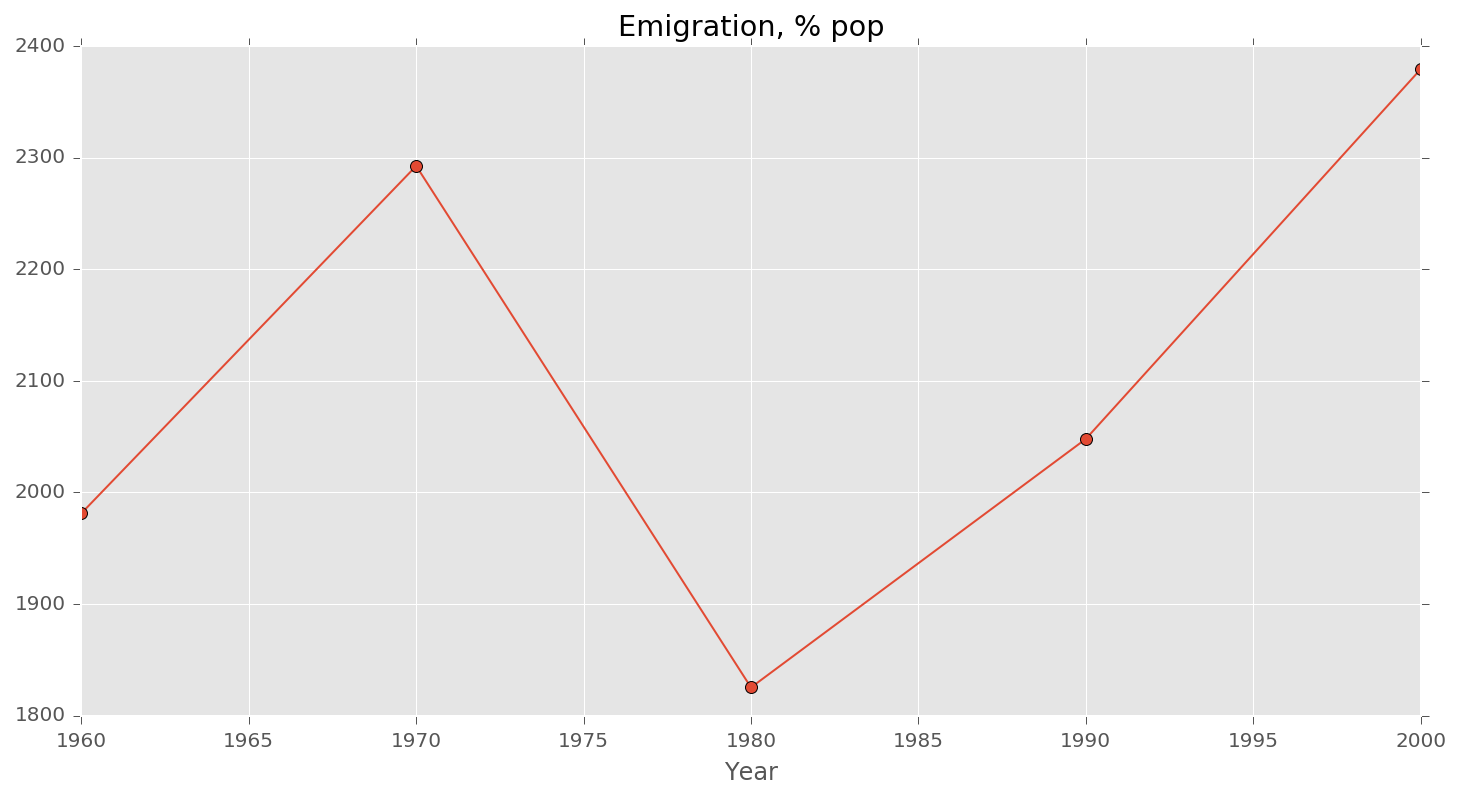

In [291]:
merged.groupby('Year').sum()['Emigration, % pop'].plot(marker='o',title='Emigration, % pop')


The plot above shows the emigration / population ration per decade. It shows a less clear trend than the data about absolute emigration. Nonetheless, emigration has increased since 1980 of more than 30 %.

Select sufficiently large country, and show the 

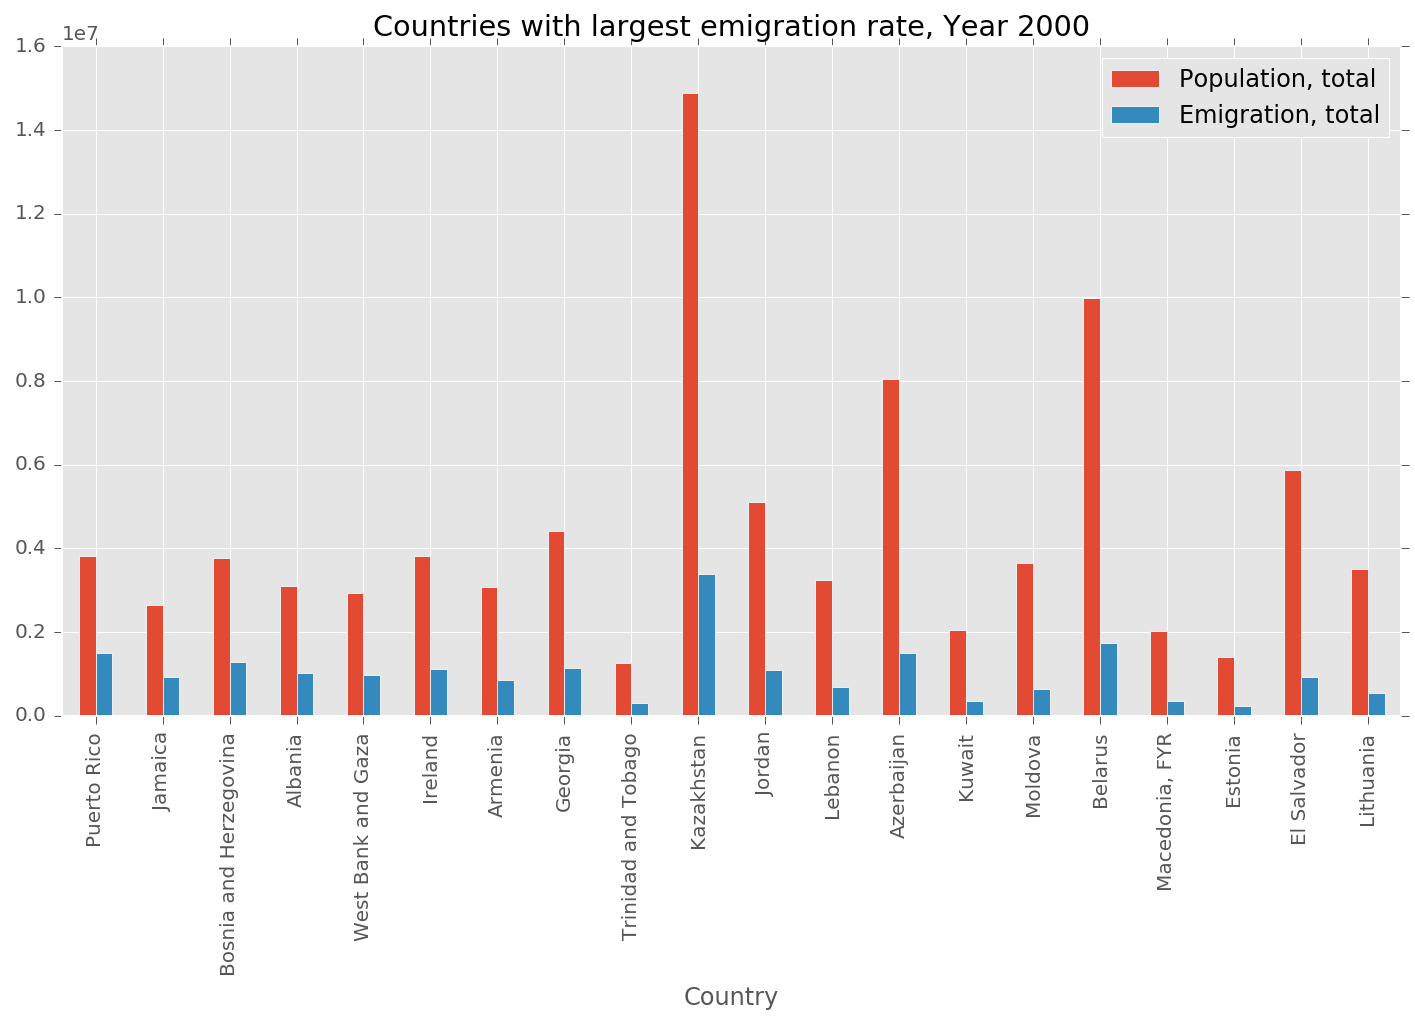

In [292]:
large_emigration_countries = merged[(merged['Population, total']>10**6) & (merged['Year']==2000)]\
.sort_values(by='Emigration, % pop', ascending=False)\
.set_index('Country')

large_emigration_countries[['Population, total','Emigration, total']].iloc[0:20].plot(kind='bar',title='Countries with largest emigration rate, Year 2000')

(0, 14000000.0)

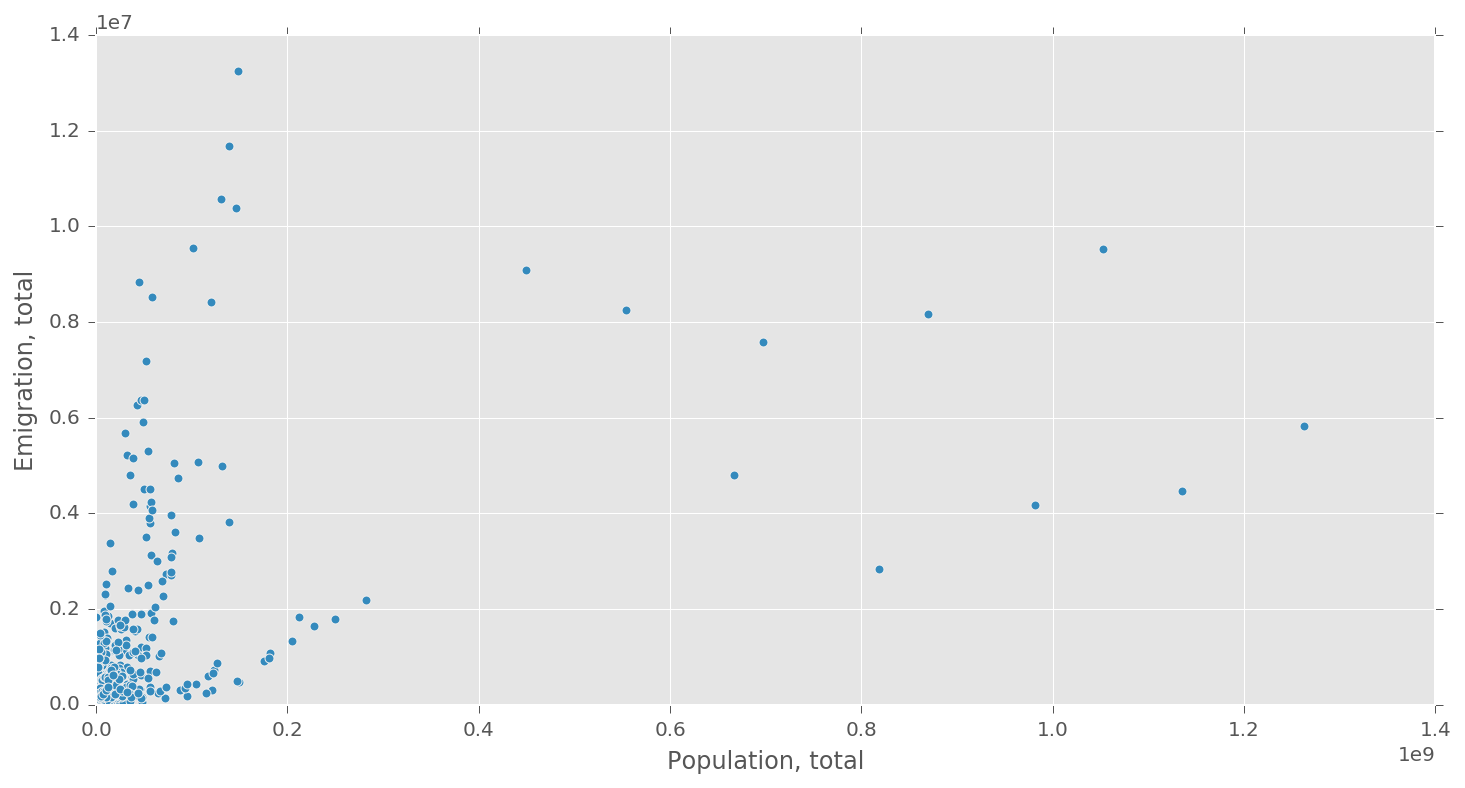

In [293]:
merged.plot(kind='scatter',y='Emigration, total',x='Population, total')
plt.xlim(0)
plt.ylim(0)

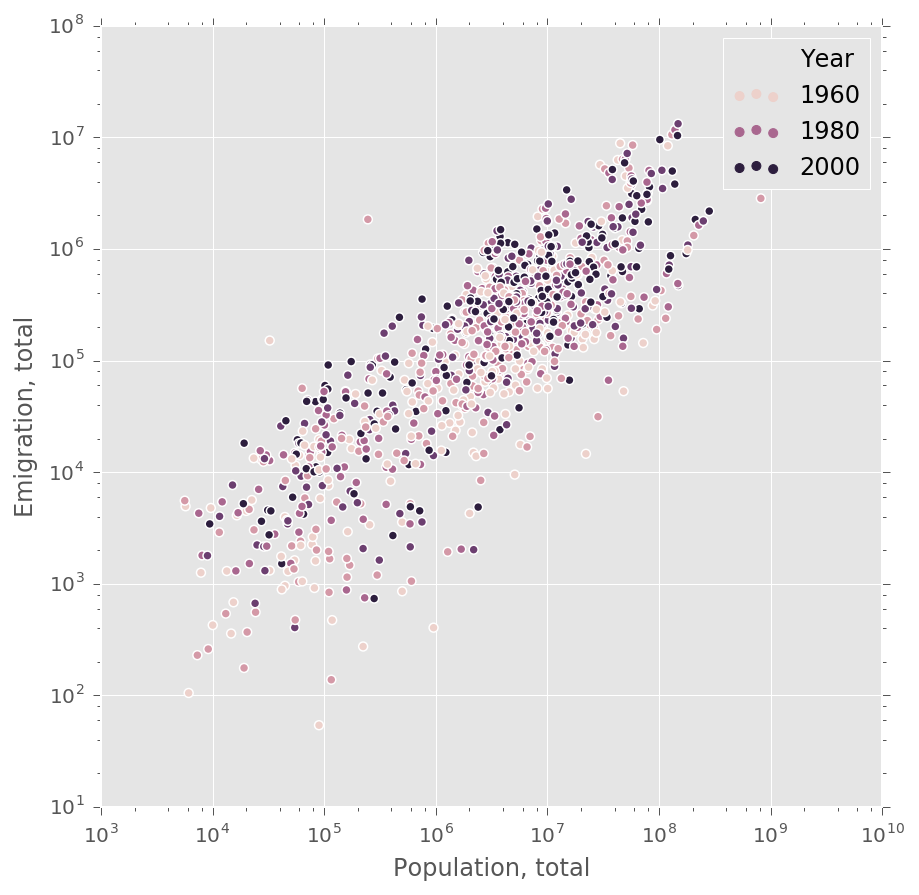

In [294]:
#plot1 = merged.plot(kind='scatter',y='Emigration, % pop',x='Population, total')
plt.figure(figsize=(7,7))
plot1 = sns.scatterplot(data=merged,y='Emigration, total',x='Population, total',hue='Year' )
plot1.set_xscale('log')
plot1.set_yscale('log')
#plot1.xlim(0)
#plot1.ylim(0)

The larger the country, the larger the emigration. Intuitive. Still countries of same dimension 1-2 orders of magnitude of difference in emigration. See also the general increase of emigration over the year.

In [310]:
merged[merged['Year']==1990]

Country  Year  Emigration, total  GDP per capita  \
3                  Afghanistan  1990          1054244.0             NaN   
8                      Albania  1990           206232.0     4722.838166   
13                     Algeria  1990          1574045.0    10236.840658   
18              American Samoa  1990             3443.0             NaN   
23                     Andorra  1990              405.0             NaN   
28                      Angola  1990           269542.0     3430.798427   
33                    Anguilla  1990             3074.0             NaN   
38         Antigua and Barbuda  1990            27295.0    16381.018357   
43                   Argentina  1990           437051.0    10815.715123   
48                     Armenia  1990           470346.0     3742.437371   
53                       Aruba  1990             9202.0             NaN   
58                   Australia  1990           302881.0    28658.365890   
63                     Austria  1990           503127.0    31341.902381   
68                  Azerbaijan  1990          1016910.0     8513.310693   
73                Bahamas, The  1990            29583.0    30991.968343   
78                     Bahrain  1990            14412.0    35113.332939   
83                  Bangladesh  1990          5068368.0     1287.933664   
88                    Barbados  1990            92411.0    14434.329320   
93                     Belarus  1990          2529435.0     8353.906165   
98                     Belgium  1990           410160.0    30647.821348   
103                     Belize  1990            41297.0     5165.867220   
108                      Benin  1990           267610.0     1462.677421   
113                    Bermuda  1990            18142.0    40553.258521   
118                     Bhutan  1990            14667.0     2325.241884   
123                    Bolivia  1990           226404.0     3707.244930   
128     Bosnia and Herzegovina  1990           827746.0             NaN   
133                   Botswana  1990            73696.0     8110.440465   
138                     Brazil  1990           470599.0    10344.864390   
143          Brunei Darussalam  1990            87102.0    84672.391499   
148                   Bulgaria  1990           652211.0     9296.952206   
...                        ...   ...                ...             ...   
1013                Tajikistan  1990           334752.0     3644.666922   
1018                  Tanzania  1990           209580.0     1472.583750   
1023                  Thailand  1990           294055.0     6650.439738   
1028               Timor-Leste  1990             3578.0             NaN   
1033                      Togo  1990           167878.0     1350.133276   
1038                   Tokelau  1990             1872.0             NaN   
1043                     Tonga  1990            28177.0     3574.195232   
1048       Trinidad and Tobago  1990           209290.0    12255.413886   
1053                   Tunisia  1990           567801.0     5614.938383   
1058                    Turkey  1990          2508368.0    11400.178144   
1063              Turkmenistan  1990           323735.0     8316.756977   
1068  Turks and Caicos Islands  1990             4017.0             NaN   
1073                    Tuvalu  1990             1787.0     2353.715762   
1078                    Uganda  1990           204453.0      769.452484   
1083                   Ukraine  1990          7178761.0    10463.959955   
1088      United Arab Emirates  1990            54622.0   110432.464979   
1093            United Kingdom  1990          4231146.0    26827.842264   
1098             United States  1990          1781009.0    37062.130260   
1103                   Uruguay  1990           223213.0     9840.720070   
1108                Uzbekistan  1990          1148857.0     3071.022647   
1113                   Vanuatu  1990             4875.0     2549.287954   
1118             Venezuela, RB  1990           2

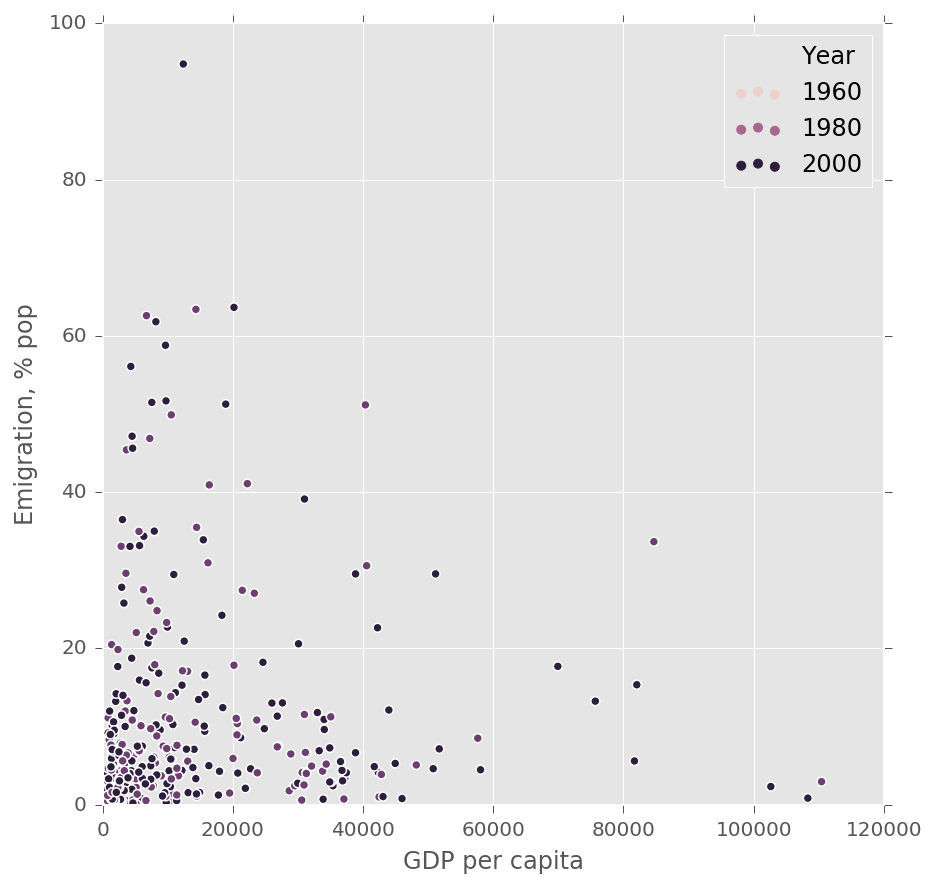

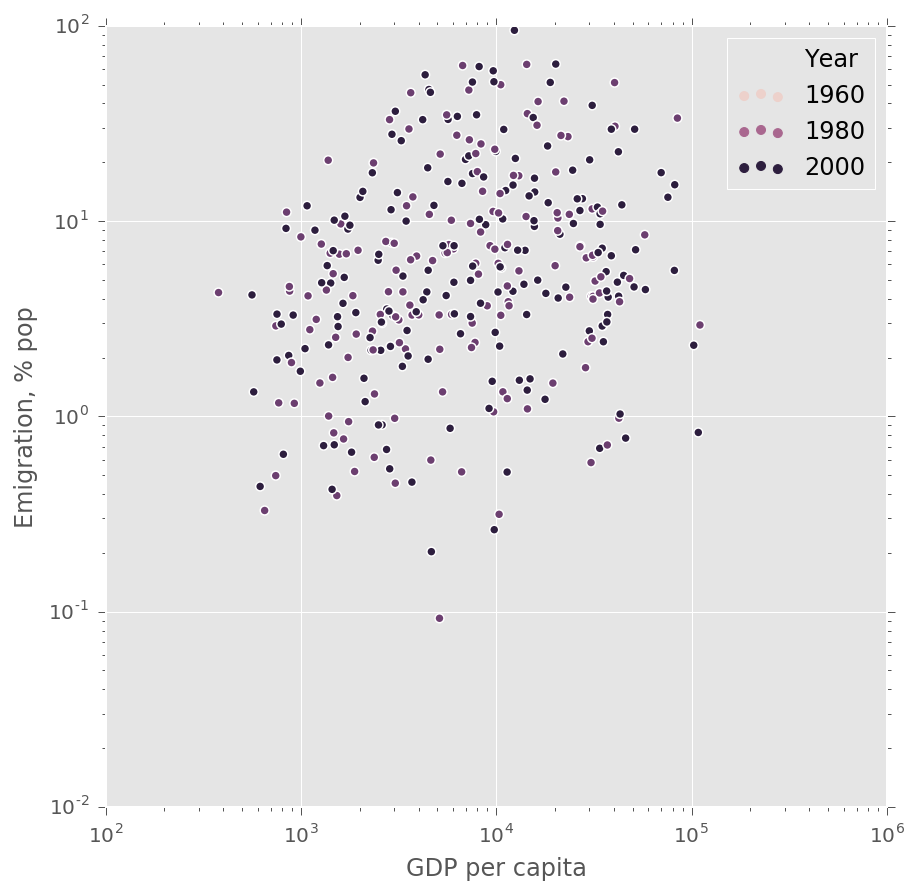

In [321]:
plt.figure(figsize=(7,7))
plot1 = sns.scatterplot(data=merged,x='GDP per capita',y='Emigration, % pop',hue='Year')
plt.xlim(0)
plt.ylim(0)

plt.figure(figsize=(7,7))
plot1 = sns.scatterplot(data=merged,y='Emigration, % pop',x='GDP per capita',hue='Year' )
plot1.set_xscale('log')
plot1.set_yscale('log')

Middle level countries have a larger share of emigration. Economic conditions, however, explain only partially the migration process. It looks that poorest countries (GDP per capita less than 2000 suffer of a "poverty-trap" effect.

In [313]:
df_indicators = pd.read_csv('data/indicators.csv')

In [314]:
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5656458 entries, 0 to 5656457
Data columns (total 6 columns):
CountryName      object
CountryCode      object
IndicatorName    object
IndicatorCode    object
Year             int64
Value            float64
dtypes: float64(1), int64(1), object(4)
memory usage: 258.9+ MB


In [315]:
del df_indicators['CountryCode']
del df_indicators['IndicatorCode']

In [316]:
# select relevant year
years_migr_int = [int(year) for year in years_migration]
df_indicators_years = select_years (df_indicators, 'Year',years_migr_int )
df_indicators_years.columns = ['Country','Indicator','Year','Value']
df_indicators_years.head()

Country                                          Indicator  Year  \
0  Arab World  Adolescent fertility rate (births per 1,000 wo...  1960   
1  Arab World  Age dependency ratio (% of working-age populat...  1960   
2  Arab World  Age dependency ratio, old (% of working-age po...  1960   
3  Arab World  Age dependency ratio, young (% of working-age ...  1960   
4  Arab World        Arms exports (SIPRI trend indicator values)  1960   

          Value  
0  1.335609e+02  
1  8.779760e+01  
2  6.634579e+00  
3  8.102333e+01  
4  3.000000e+06

In [317]:
df_indicators_years_pivot = df_indicators_years.pivot_table(index=['Country','Year'],columns='Indicator',values='Value')
df_indicators_years_pivot = df_indicators_years_pivot.reset_index()

In [324]:
# merge data-sets
data_set = emigration.merge(df_indicators_years_pivot,how='left',on=['Country','Year'])
data_set.head()

Country  Year  Emigration, total  \
0  Afghanistan  1960            84039.0   
1  Afghanistan  1970           131126.0   
2  Afghanistan  1980           373995.0   
3  Afghanistan  1990          1054244.0   
4  Afghanistan  2000          1179710.0   

   ARI treatment (% of children under 5 taken to a health provider)  \
0                                                NaN                  
1                                                NaN                  
2                                                NaN                  
3                                                NaN                  
4                                                NaN                  

   Access to electricity (% of population)  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                 34.61567   
4                                 37.45584   

   Access to electricity, rural (% of rural population)  \
0                                                NaN      
1                                                NaN      
2                                                NaN      
3                                           20.36011      
4                                           24.28065      

   Access to electricity, urban (% of urban population)  \
0                                                NaN      
1                                                NaN      
2                                                NaN      
3                                          98.872860      
4                                          88.290707      

   Access to non-solid fuel (% of population)  \
0                                         NaN   
1                                         NaN   
2                                         NaN   
3                                    4.111767   
4                                   13.708556   

   Adjusted net enrolment rate, primary, both sexes (%)  \
0                                                NaN      
1                                                NaN      
2                                                NaN      
3                                                NaN      
4                                                NaN      

   Adjusted net enrolment rate, primary, female (%)  \
0                                               NaN   
1                                               NaN   
2                                               NaN   
3                                               NaN   
4                                               NaN   

                           ...                            \
0                          ...                             
1                          ...                             
2                          ...                             
3                          ...                             
4                          ...                             

   Women who believe a husband is justified in beating his wife when she argues with him (%)  \
0                                                NaN                                           
1                                                NaN                                           
2                                                NaN                                           
3                                                NaN                                           
4                                                NaN                                           

   Women who believe a husband is justified in beating his wife when she burns the food (%)  \
0                                                NaN                                          
1                                                NaN                                          
2                                                NaN                                          
3                                  

### Cleaning datasets
The indicator dataset is not ready-to-use. It contains an very large number of missing data. 

In [244]:
data_set.isnull().sum()
data_set.shape

(1160, 1142)

(1160,)

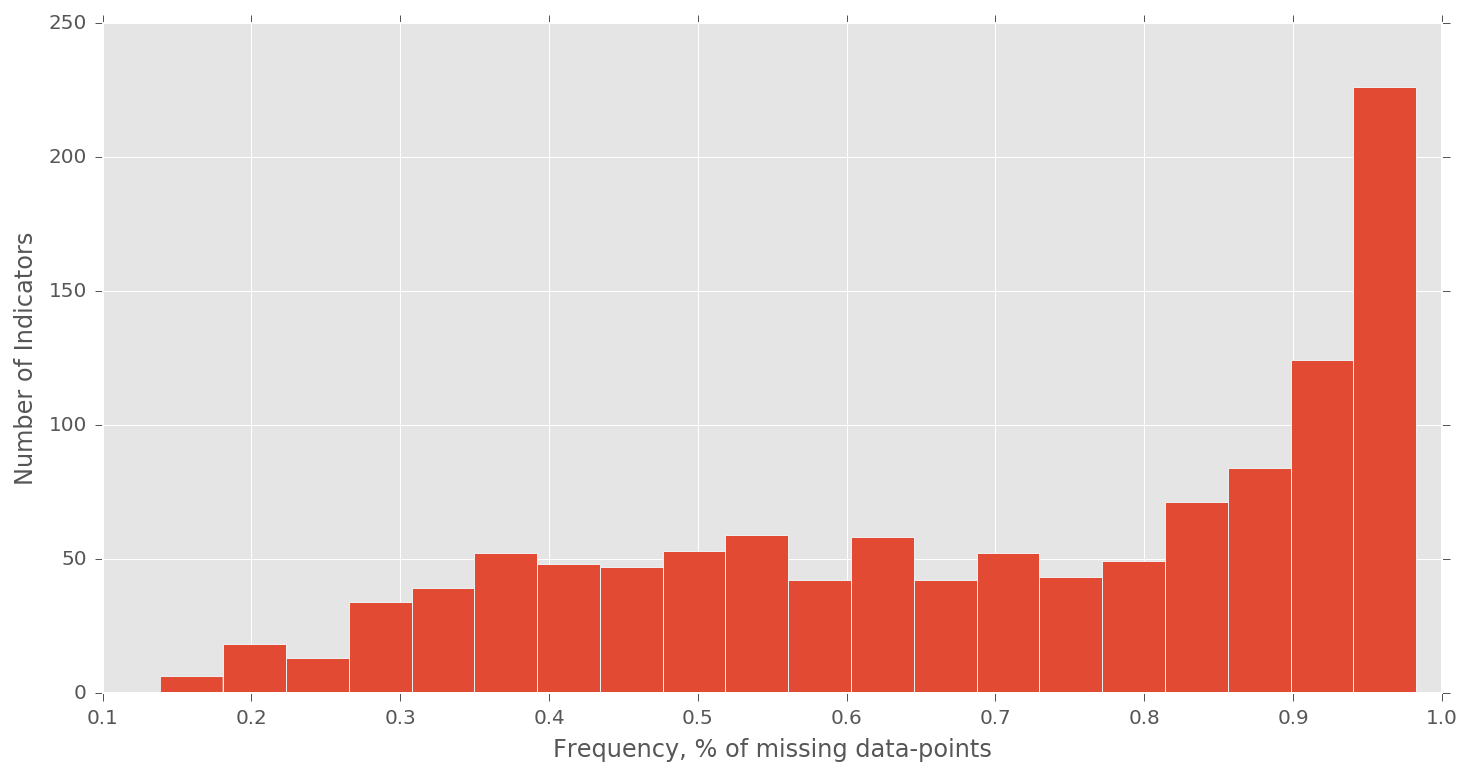

In [353]:
# statistics on missing data

plt.hist(data_set.isnull().sum(1).values/data_set.shape[0],bins=20)
plt.ylabel('Number of Indicators')
plt.xlabel('Frequency, % of missing data-points')
data_set.isnull().sum(1).shape

There are data-points that are poorly populated. These should also be removed.

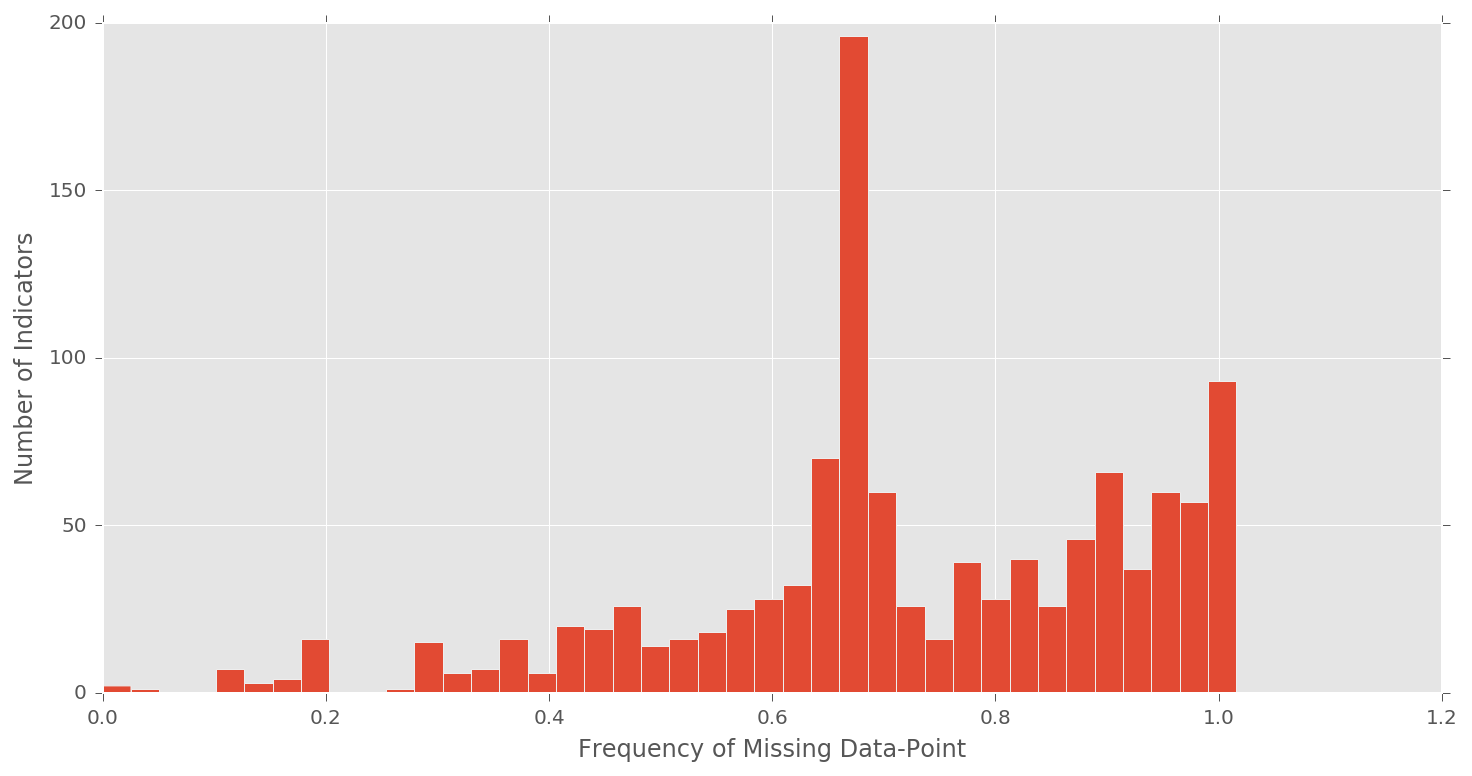

In [357]:
plt.hist(data_set.isnull().sum()/data_set.shape[1],bins=40)
plt.xlabel('Frequency of Missing Data-Point')
plt.ylabel('Number of Indicators')

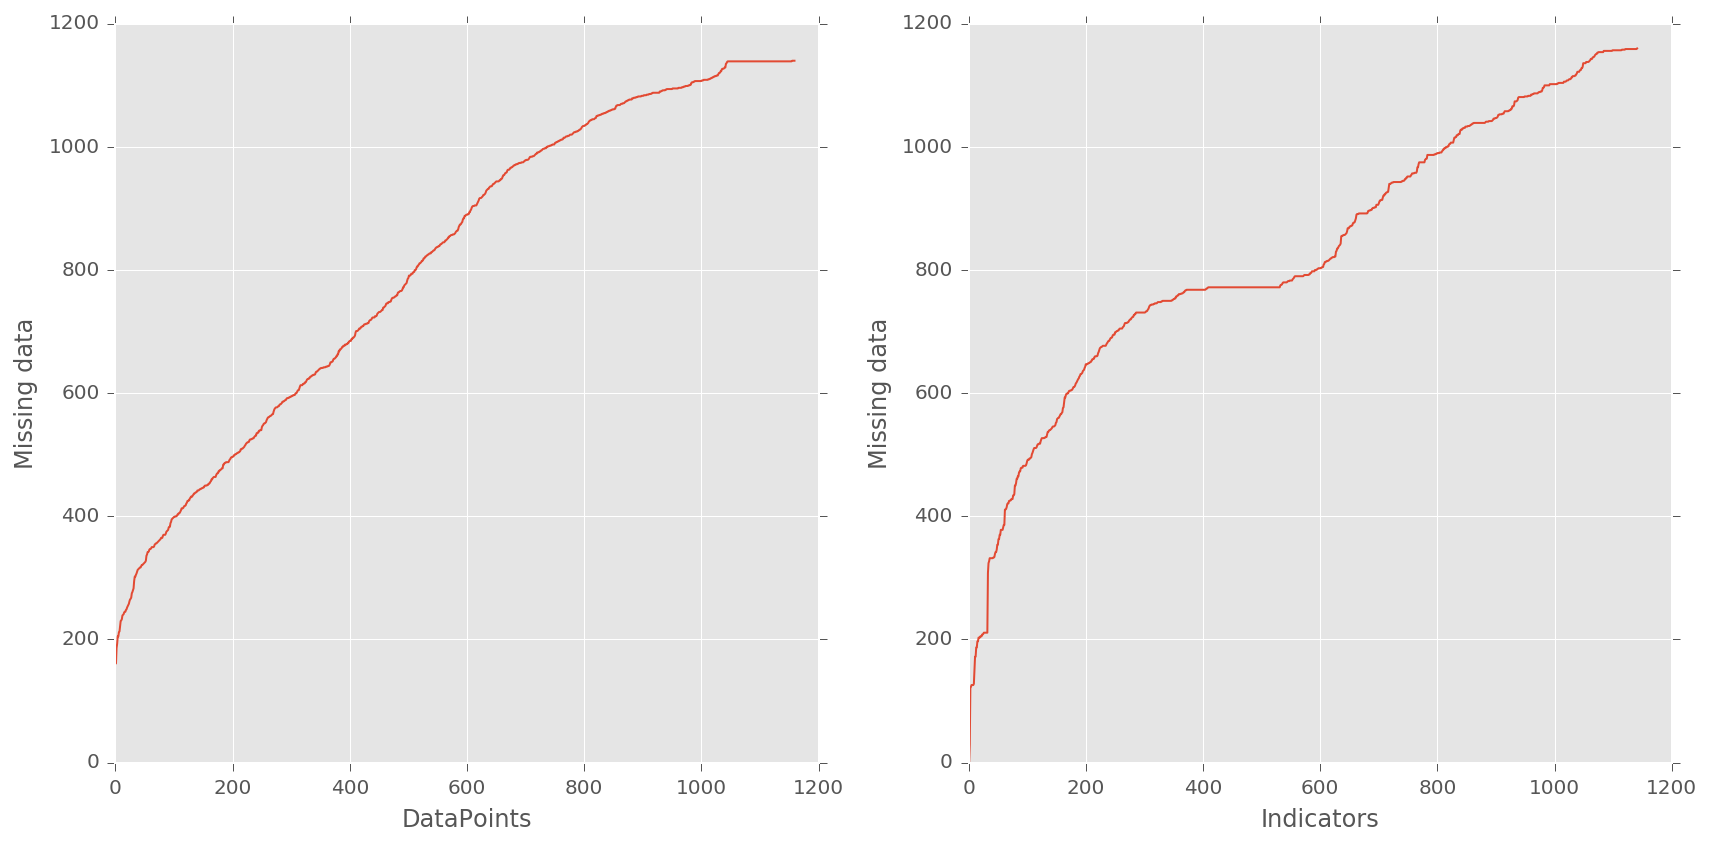

In [356]:
plt.subplot(121)
miss_data = data_set.isnull().sum(1).sort_values().values
plt.plot(miss_data);plt.xlabel('DataPoints');plt.ylabel('Missing data')
plt.subplot(122)
miss_ind = data_set.isnull().sum().sort_values().values
plt.plot(miss_ind);plt.xlabel('Indicators');plt.ylabel('Missing data')
plt.tight_layout()



The function smart_cut drops rows and columns with a large number of missing data, until a small percentage of missing value, considered acceptable is reached. The wheight modulates the importance of keeping columns. Since we prefer to have more datapoints than indicators, we will set this parameter at a value lower than 1 (more weights to data-points) 

In [346]:
from migration import smart_cut, order_by_nan,sel_regressor    

In [358]:
threshold = 0.10
weight_ind = 0.1
data_set_cut = smart_cut(data_set,threshold,weight_ind)

In [359]:
print('Using these parameters, we keep ' + str(data_set_cut.shape[0]) + ' datapoints and '+ 
      str(data_set_cut.shape[1]-2) + ' indicators')

Using these parameters, we keep 790 datapoints and 113 indicators


Below the retained indicators, and the number of missing values.

In [360]:
data_set_cut.isnull().sum().sort_values(ascending=False)

Gross domestic savings (% of GDP)                                                               157
Gross national expenditure (% of GDP)                                                           157
Final consumption expenditure, etc. (% of GDP)                                                  157
Final consumption expenditure, etc. (current LCU)                                               157
Gross domestic savings (current LCU)                                                            157
CO2 emissions (kg per 2005 US$ of GDP)                                                          153
Merchandise exports to high-income economies (% of total merchandise exports)                   152
Gross capital formation (% of GDP)                                                              151
Merchandise imports from developing economies in South Asia (% of total merchandise imports)    149
Gross capital formation (current LCU)                                                           149


We now fill the remaining missing data with the average of its columns. There are probably better way to do this, but we will explore them in a second stage. 

In [361]:
data_set_cut = data_set_cut.fillna(data_set_cut.median())

___
Let's check the consistency, presence of outliers, etc

Delete of LCU, Local current unit. Make little sense. 


In [93]:
containts_LCU = [s for s in data_set_cut.columns if 'LCU' in s]
data_set_cut = data_set_cut.drop(containts_LCU, axis=1)

We now have a clean dataset, to be used for training a model

(0, 14000000.0)

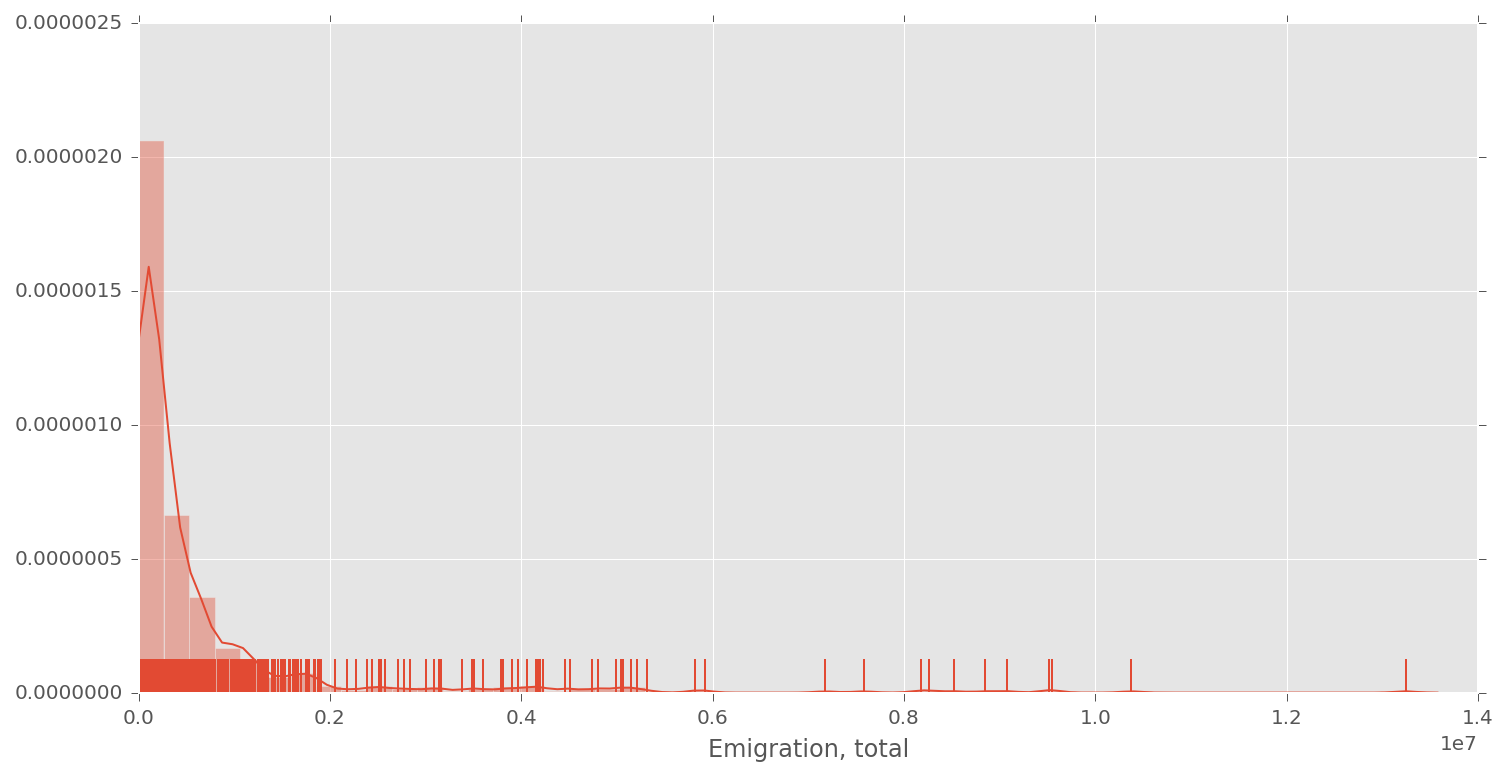

In [363]:
sns.distplot(data_set_cut['Emigration, total'],rug=True)
plt.xlim(0)

Much skewed distribution. A model using these data would be dominated by the few extreme values. We transform the data, log ()

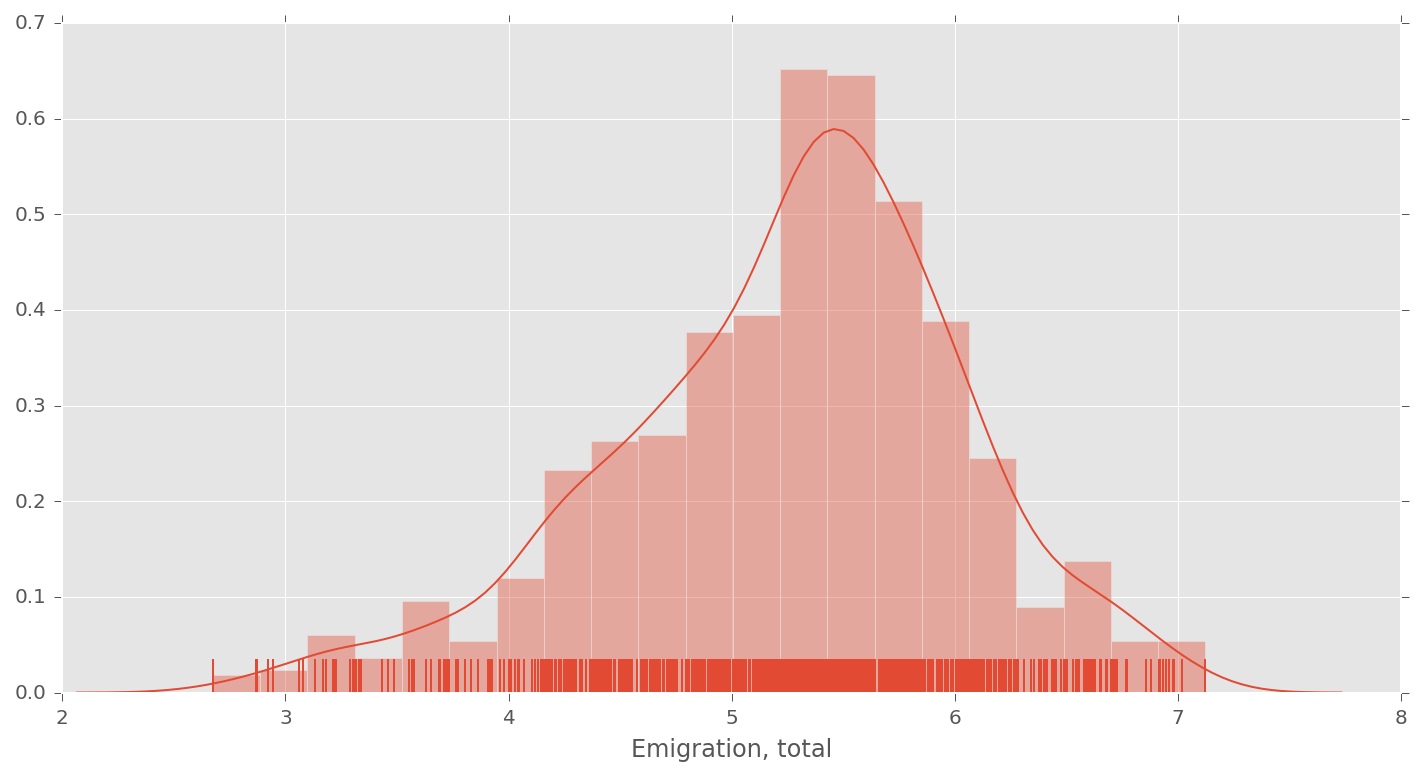

In [365]:
sns.distplot(np.log10(data_set_cut['Emigration, total']),rug=True)

Much better shaped distribution. 

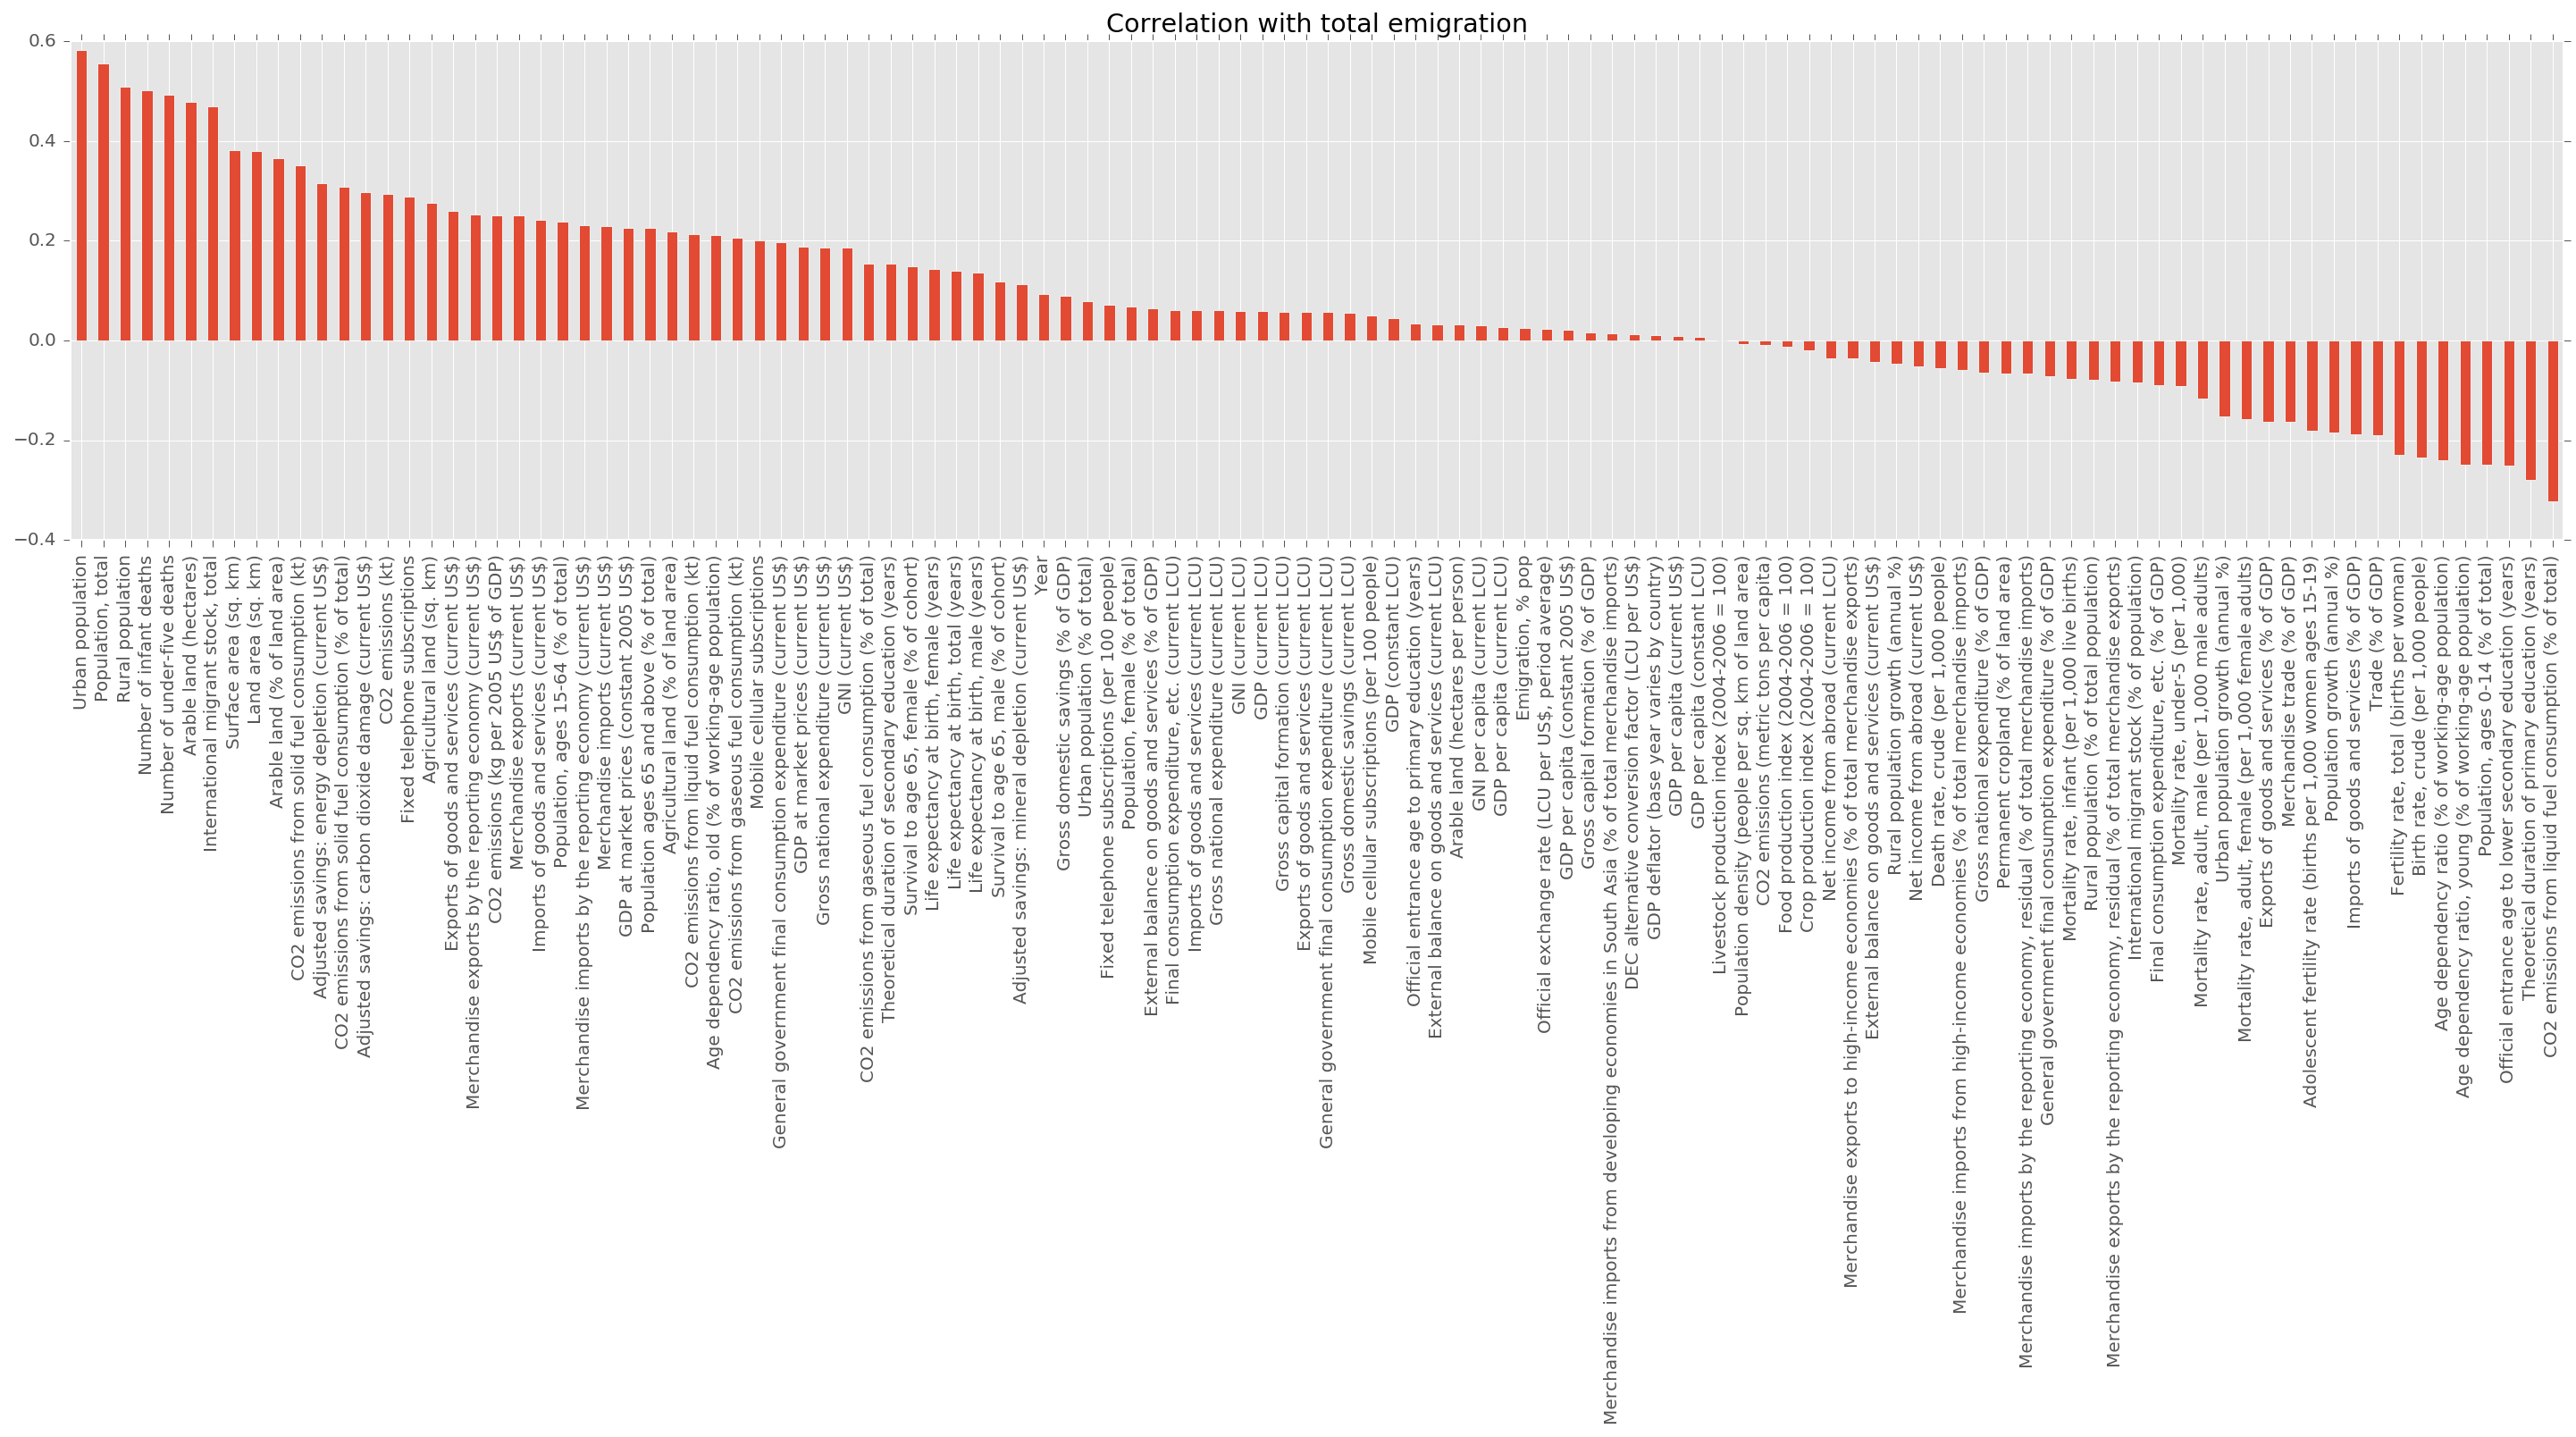

In [403]:
data_set_cut.corr()['Emigration, total'].drop('Emigration, total').sort_values(ascending=False).plot(kind='bar',figsize=(25,5),title='Correlation with total emigration')


In [410]:
data_set_cut['Emigration, % pop'] = data_set_cut['Emigration, total']/data_set_cut['Population, total']*100

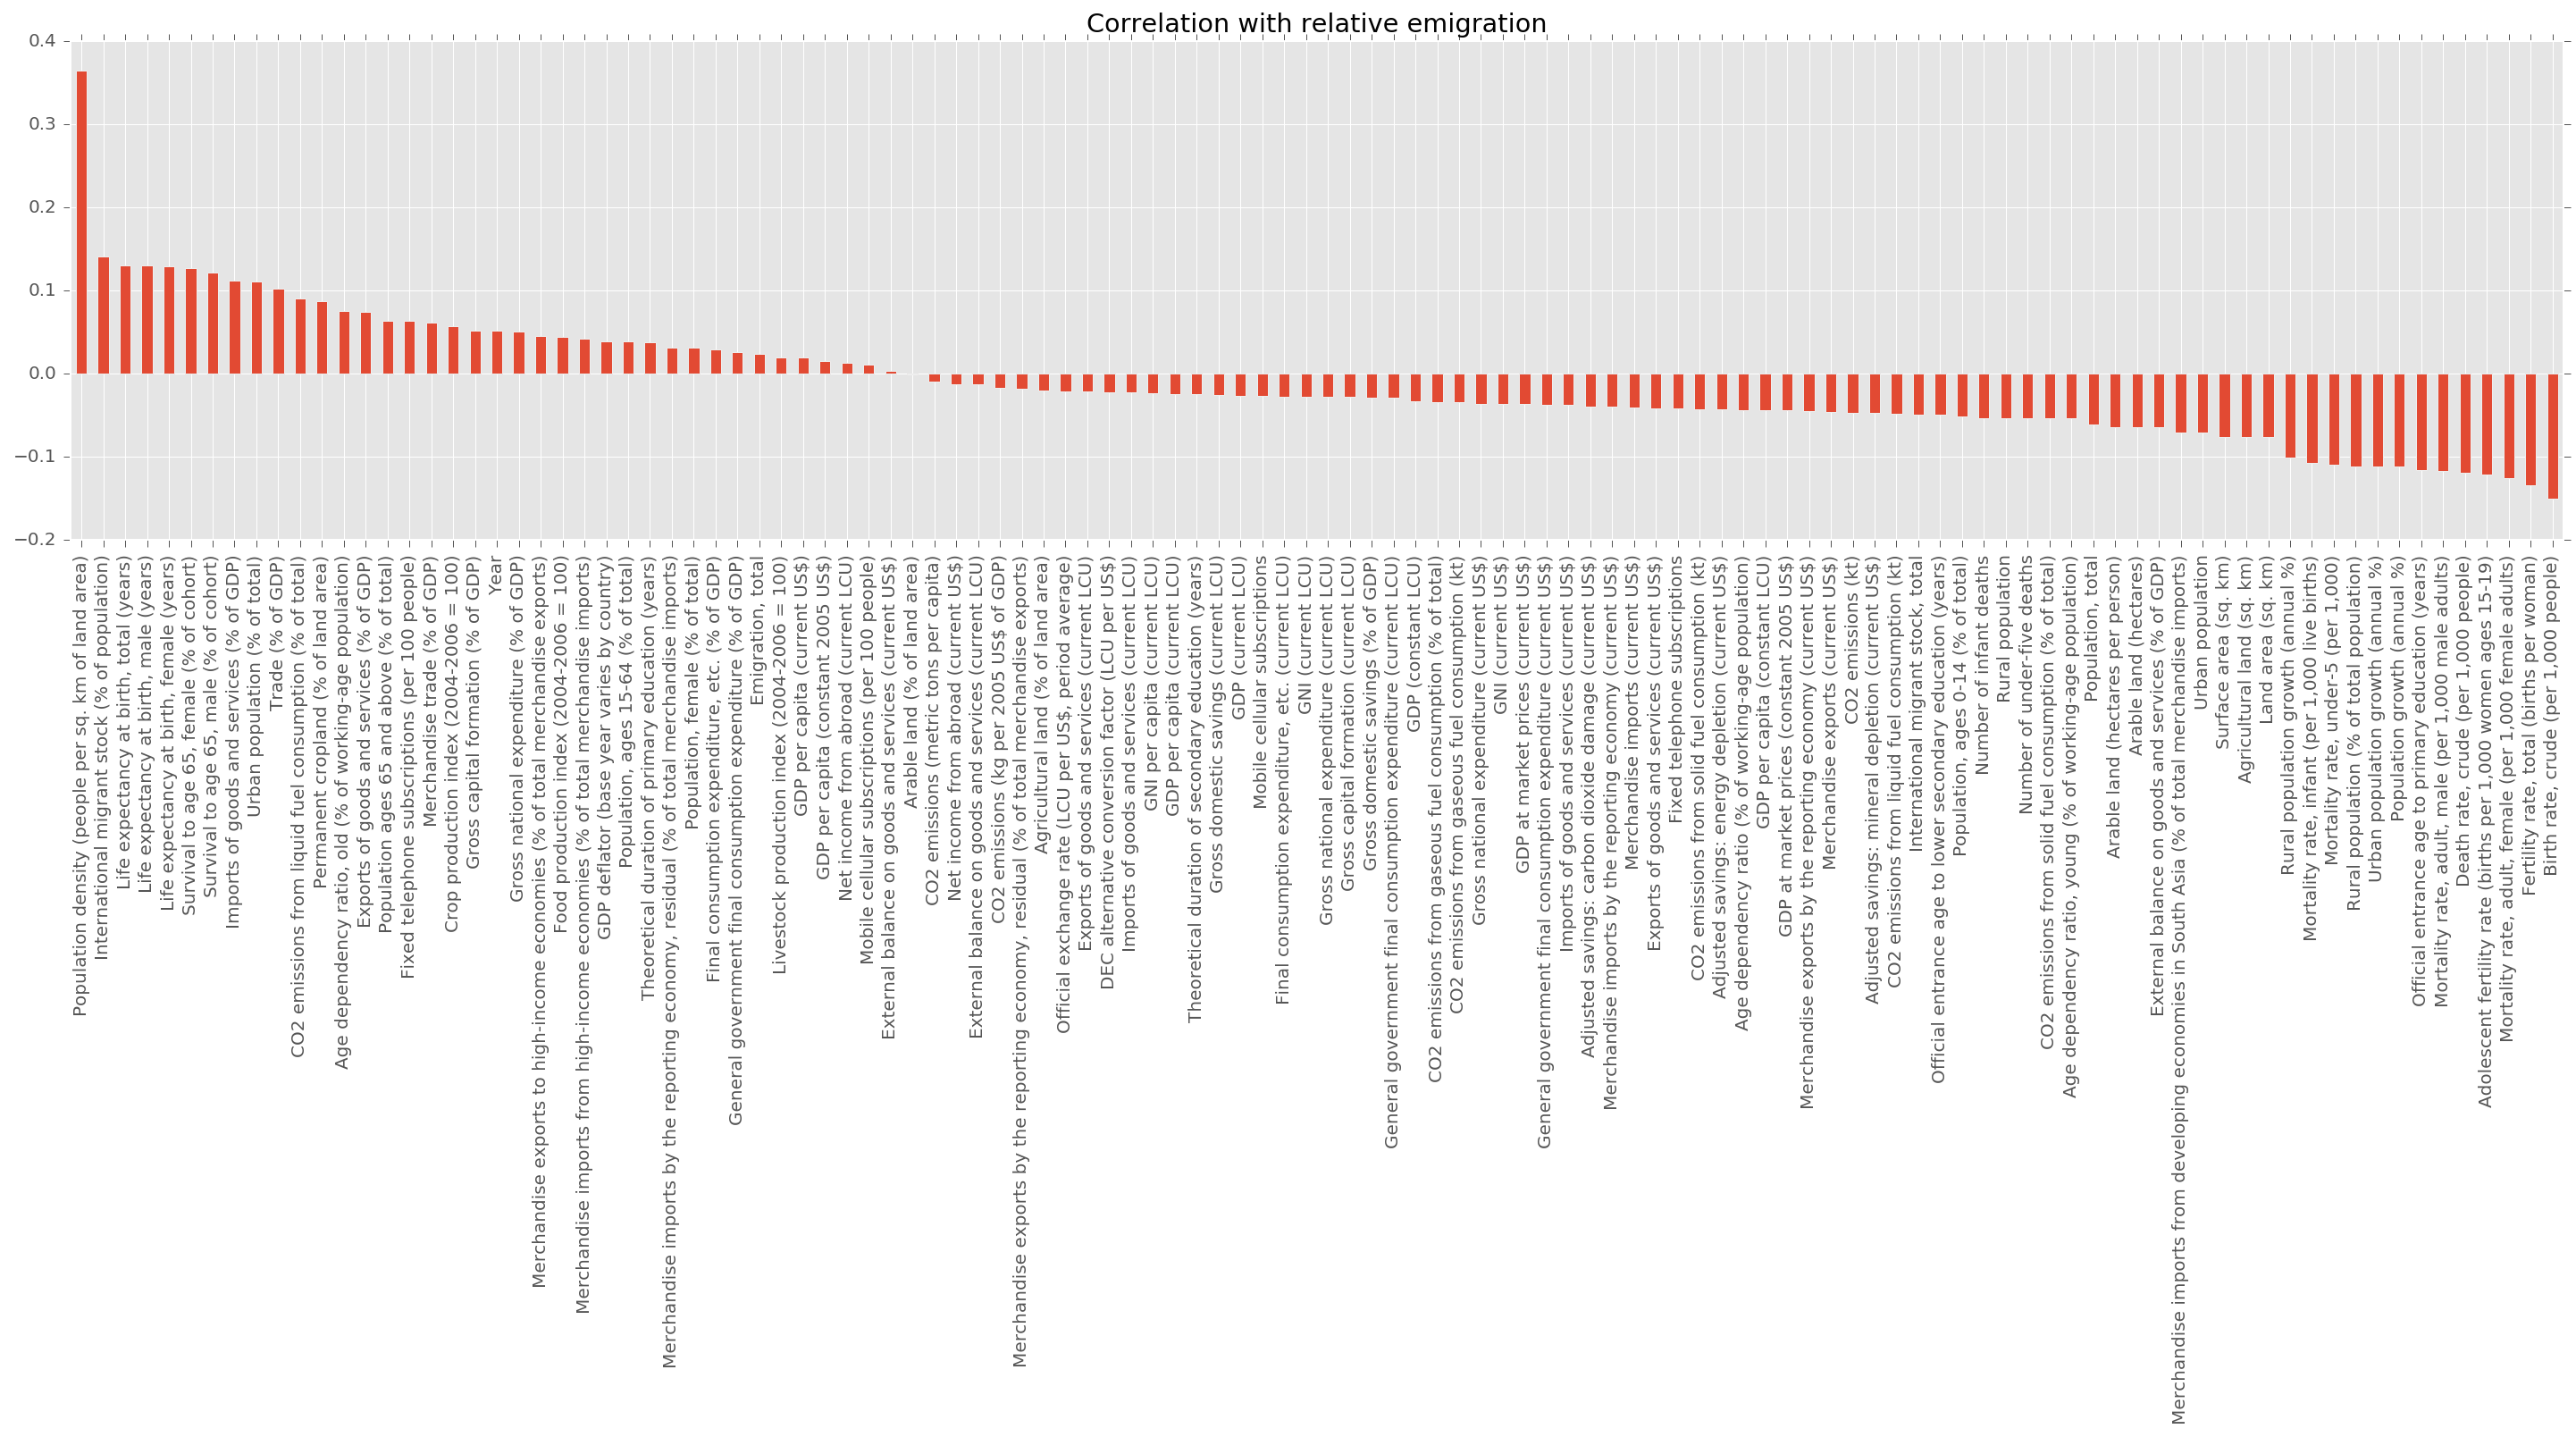

In [411]:
data_set_cut.corr()['Emigration, % pop'].drop('Emigration, % pop').sort_values(ascending=False).plot(kind='bar',figsize=(25,5),title='Correlation with relative emigration')


[]

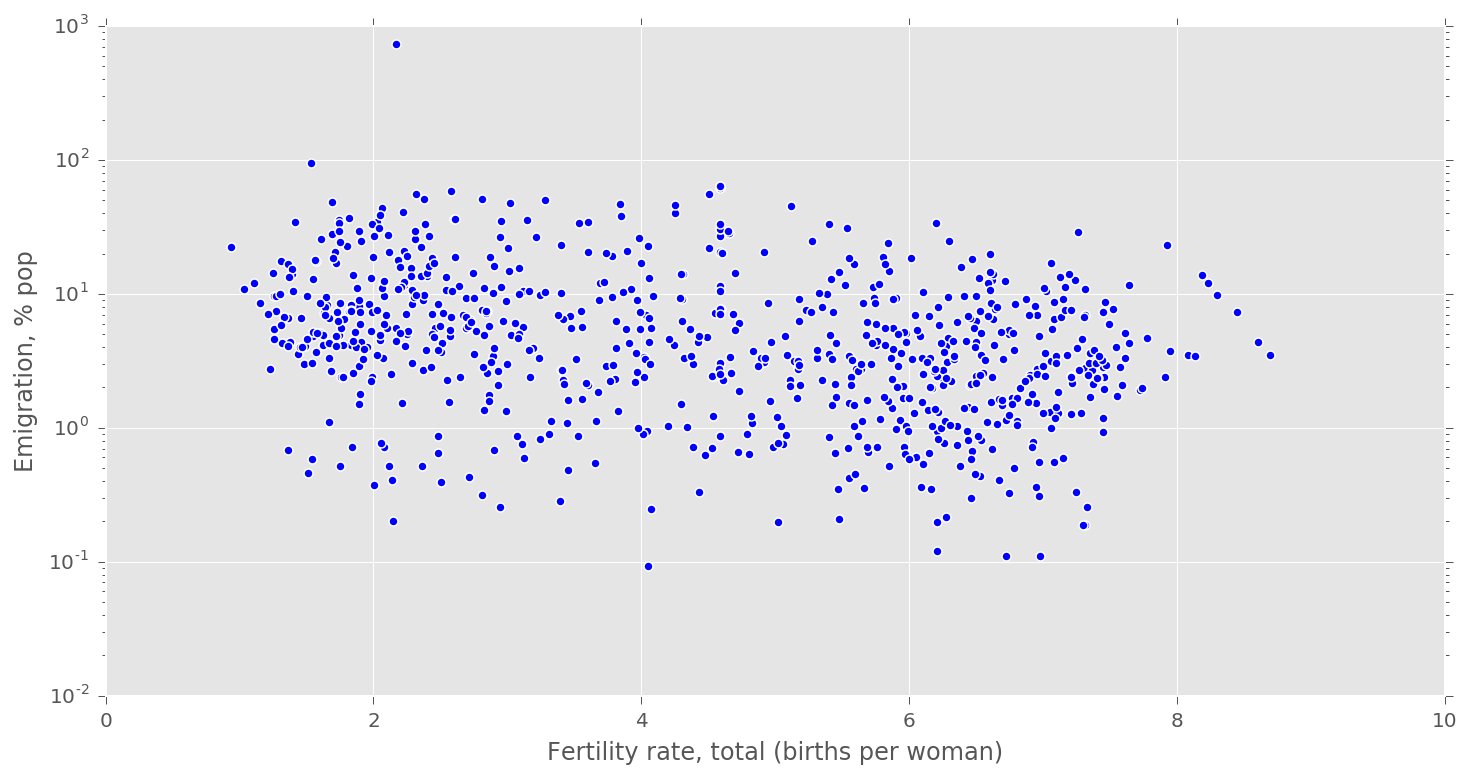

In [400]:
sns.scatterplot(data=data_set_cut,y='Emigration, % pop',x='Fertility rate, total (births per woman)').semilogy()#,hue='Region')

In [412]:
data_corrected = pd.DataFrame()
for column in data:
    if all(data_set_cut[column]>0):
        data_corrected['Log of '+column] = data_set_cut[column].apply(np.log10)
    else:
        data_corrected[column] = data[column]

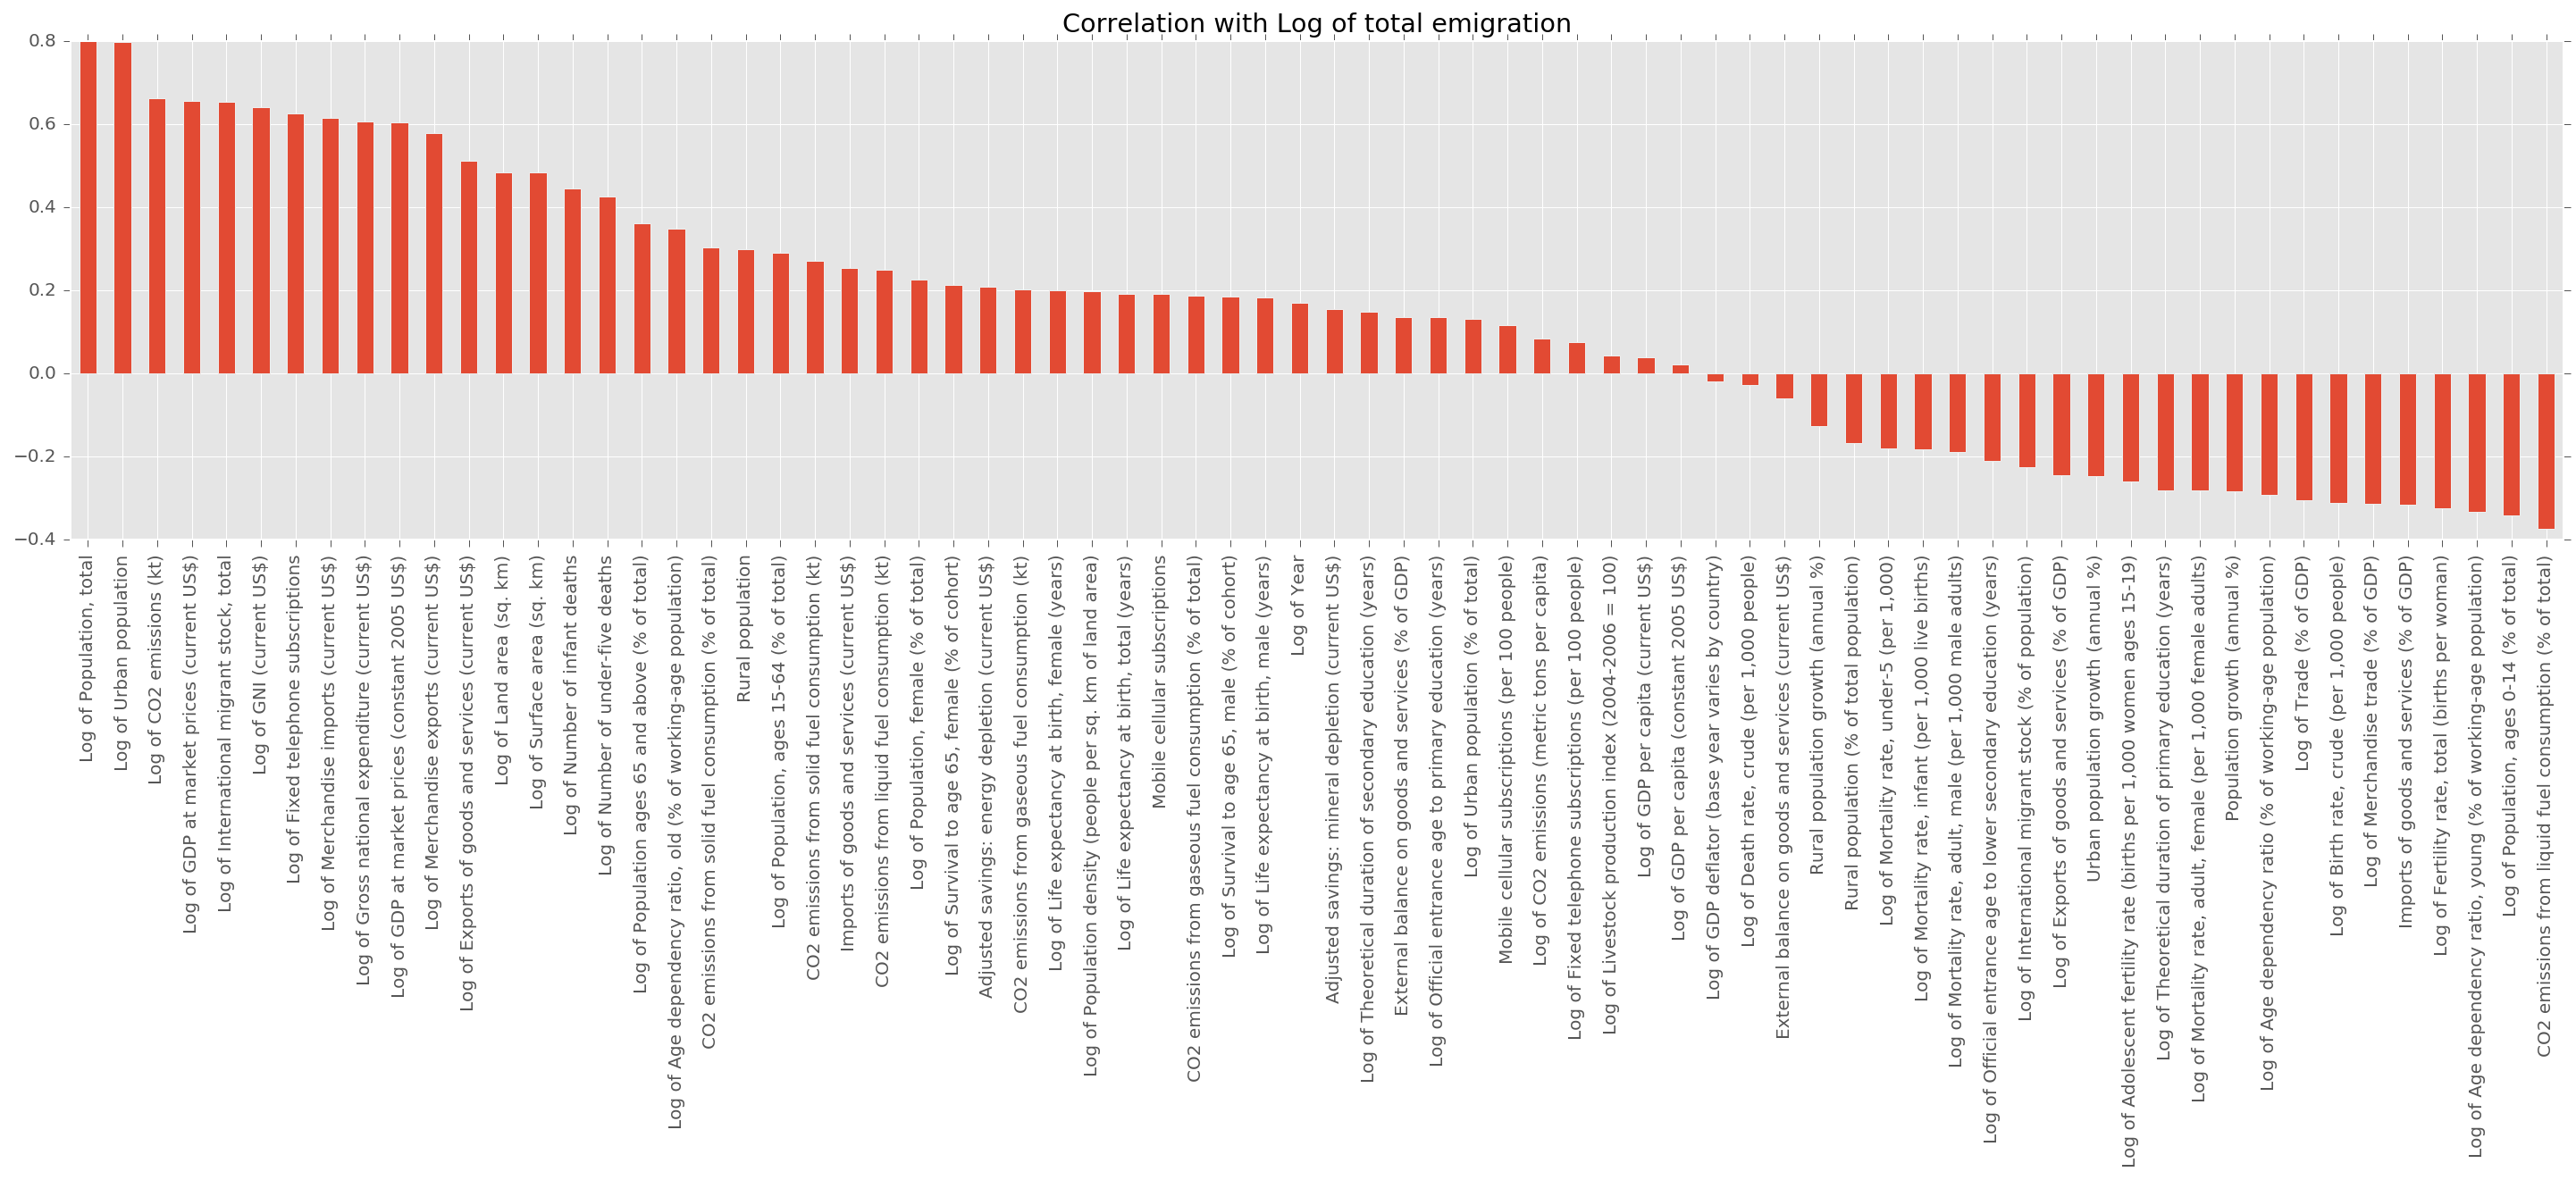

In [413]:
data_corrected.corr()['Log of Emigration, total'].drop('Log of Emigration, total').sort_values(ascending=False).plot(kind='bar',figsize=(25,5),title='Correlation with Log of total emigration')


In [414]:

data_corrected.corr()['Log of Emigration, % pop'].drop('Log of Emigration, % pop').sort_values(ascending=False).plot(kind='bar',figsize=(25,5),title='Correlation with relative emigration')


KeyError: 'Log of Emigration, % pop'